## Evolution of the Informational Complexity of Contemporary Western Music

In [1]:
import math
import numpy as np
import random as rnd
import scipy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Data Retrieval

In [ ]:
#Note that data files are not included in this directory but can be reconstructed by querying the MSD for the requisite fields
#from the list of song ids used in the dataset

In [5]:
#calculate entropy based on scipy
def entropy(array):
    elements={}
    for element in array:
        elements.setdefault(element,0)
        elements[element]+=1
    pk=[elements[k] for k in elements]
    return scipy.stats.entropy(pk,base=2)

In [6]:
#conditional entropy function, can be used with multiple priors (lookback argument)
def conditionalEntropy(array,lookback=1): #look back one position by default
    uniques={}
    biuniques={}
    priors={} #count how many times x is a prior to some y
    total=len(array)
    for element in array:
        element=str(element)
        if not(element in uniques): uniques[element]=1
        else: uniques[element]+=1
    #create array of instances of x and y together
    for i in range(total):
        if i<lookback: pass
        else: 
            bielement=""
            for j in range(lookback,0,-1): #count backwards
                bielement+=","+str(array[i-j])
            prior=bielement #count priors, do not count current y; may be one or multiple elements
            if not(prior in priors): priors[prior]=1
            else: priors[prior]+=1
            bielement+=","+str(array[i]) #add current element
            if not(bielement in biuniques): biuniques[bielement]=1
            else: biuniques[bielement]+=1
    #print total,len(uniques),len(biuniques),len(priors)
    #print priors.keys()[:10], biuniques.keys()[:10]
    conEntropy=0
    for key in biuniques: #look at Y|X
        #pkey=float(biuniques[key])/total
        prior=key[:key.rfind(",")] #cut out last element
        px=float(priors[prior])/(total-lookback)
        pcon=float(biuniques[key])/priors[prior]
        conEntropy+=pcon*math.log(pcon,2)*px
    return conEntropy*-1

In [10]:
#shortcut to populate timbre thresholds for each element in the timbre vector (minus the loudness component), based on the 10,000 song subset
thresholds=[(-18.013999999999999, 36.572000000000003),(-15.398999999999999, 30.408999999999999),(-12.234, 17.236999999999998),(-18.550999999999998, 11.664999999999999),(-23.155999999999999, 0.99399999999999999),(-14.17, 9.3079999999999998),(-10.507999999999999, 6.9219999999999997),(-5.6420000000000003, 12.021000000000001),(-4.6890000000000001, 9.907),(-6.1059999999999999, 6.7590000000000003),(-4.8019999999999996, 10.147)]
print(len(thresholds))

11


In [3]:
#song class for reading from data file; contains just metadata necessary for analysis
class SongData:
    def __init__(self,array):
        #initialization from aggregate text file
        self.song=array[0]
        self.aname=array[1]
        self.title=array[2]
        self.duration=float(array[3])
        self.tempo=float(array[4])
        self.year=int(array[5])
        self.terms=array[6]
        #indexed zip, shannon, conditional, average; leave out if equal to 0 (does not convert to float)
        try:
            self.totalEntropies=[float(l) for l in arr[7].strip("[").strip("]").split(",")] #if l!='0']
        except: self.totalEntropies=["","","",""]
        self.pentropy=float(array[8])
        self.pconEntropy=float(array[9])
        self.lentropy=float(array[10])
        self.lconEntropy=float(array[11])
        self.tentropy=float(array[12])
        self.tconEntropy=float(array[13])
        self.rentropy=float(array[14])
        self.rconEntropy=float(array[15])

In [11]:
#get song pitch codewords
def calculatePE(pitches):
    #calculate pentropy and pconEntropy for song object based on pitch codewords
    pcodes=[]
    for pitch in pitches:
        codeword="" #use string representation for later comparisons
        for element in pitch:
            if element>.5: codeword+='1'
            else: codeword+='0'
        pcodes.append(codeword)
    if pcodes: return (pcodes,entropy(pcodes),conditionalEntropy(pcodes))
    else: return None

In [12]:
#get song loudness codewords; rounds to nearest decibel
def calculateLE(volumes):
    lcodes=[]
    for volume in volumes:
        lcodes.append(int(round(volume)))
        #song.lcodes.append(round(volume*5)/5) #rounds to nearest fifth of decibel
    if lcodes: return (lcodes,entropy(lcodes),conditionalEntropy(lcodes))
    else: return None 

In [13]:
#create ternary timbre codewords (based on 11 dimensional vectors); depends on thresholds set above
def calculateTE(timbres):
    tcodes=[]
    for timbre in timbres:
        codeword="" #string representation
        for i in range(11):
            if timbre[i+1]<thresholds[i][0]: codeword+='0'
            elif timbre[i+1]<thresholds[i][1]: codeword+='1'
            else: codeword+='2'
        tcodes.append(codeword)
    if tcodes: return (tcodes,entropy(tcodes),conditionalEntropy(tcodes))
    else: return None

In [14]:
#calculate rhythm based on beats in section
def calculateRE(segments,beats):
    #calculate the average beat
    rcodes=[]
    segDiffs=[]
    for i in range(len(beats)):
        if i==0: pass #skip the first iteration
        elif beats[i]==0: pass
        elif beats[i-1]==0: pass
        else: segDiffs.append(beats[i]-beats[i-1])
    average=0
    for diff in segDiffs: average+=diff
    try: average=average/len(segDiffs) #average beat
    except: #division by zero
        return #ignore song with bad beat data
    sixteenth=average/4 #sixteenth note
    #calculate rhythm in terms of number of sixteenths based on average beat
    for i in range(len(segments)): 
        if i==0: pass #skip the first iteration
        else: 
            duration=segments[i]-segments[i-1]
            rcodes.append(round(duration/sixteenth*4)/4) #can distinguish 64th notes
            #song.rcodes.append(round(duration/sixteenth*2)/2) #can distinguish 32nd notes
            #rcodes.append(round(duration/sixteenth)) #can distinguish 16th notes
    if rcodes: return (rcodes,entropy(rcodes),conditionalEntropy(rcodes))
    else: return None 

In [16]:
#recover codeword
def fromString(line):
    arr=[]
    for code in line.strip().split(",")[:-1]: 
        try: 
            arr.append(float(code))
        except ValueError:
            arr.append(code)
    return arr

In [17]:
def fromStringRecursive(line):
    arr=[]
    for code in line.strip().split(",,")[:-1]:
        arr.append(list(fromString(code+','))) #add comma to be thrown away in the fromString function
    return arr

In [15]:
#alternate version of SongData
class FullSongData:
    def __init__(self,array):
        #initialization from aggregate text file
        self.song=array[0]
        self.artist=array[1]
        self.aname=array[2]
        self.title=array[3]
        self.duration=float(array[4])
        self.key=int(array[5])
        self.loudness=float(array[6])
        self.tempo=float(array[7])
        self.timeSig=int(array[8])
        self.segments=fromString(array[9])
        self.pitches=fromStringRecursive(array[10])
        self.timbres=fromStringRecursive(array[11])
        self.volumes=fromString(array[12])
        self.sections=fromString(array[13])
        self.beats=fromString(array[14])
        self.bars=fromString(array[15])
        self.year=int(array[16])
        self.terms=fromString(array[17])
        self.term_weights=fromString(array[18])
        self.tags=fromString(array[19])
        self.energy=float(array[20])
        self.mode=int(array[21])
        self.afam=float(array[22])
        self.ahot=float(array[23])
        self.shot=float(array[24])
        self.simartists=fromString(array[25])
        #entropy calculations
        pe=calculatePE(fromStringRecursive(array[10]))
        le=calculateLE(fromString(array[12]))
        te=calculateTE(fromStringRecursive(array[11]))
        re=calculateRE(fromString(array[9]),fromString(array[14]))
        if pe: self.pcodes, self.pentropy, self.pconEntropy = pe[0], pe[1], pe[2]
        if le: self.lcodes, self.lentropy, self.lconEntropy = le[0], le[1], le[2]
        if te: self.tcodes, self.tentropy, self.tconEntropy = te[0], te[1], te[2]
        if re: self.rcodes, self.rentropy, self.rconEntropy = re[0], re[1], re[2]

In [4]:
#READ song data from file for easier retrieval, set genres dictionary
#for msd part A, takes ~40% memory if including codewords; ~10% memory for all filtered
total=0
genres={}
with open('../allsongs_filtered_new.txt', encoding="utf8") as f:
    #905896 filtered songs, 6661 bb, 39100 msdA
    for i in range(909419):  
        arr=[]
        for k in range(16): #16 for thin version, 26 for full version
            arr.append(f.readline().strip())
        #song=FullSongData(arr)
        try: song=SongData(arr)
        except: 
            #print(arr[:4])
            break
        try:
            genres.setdefault(song.terms,set([])).add(song)
        except IndexError: 
            genres.setdefault('unknown',set([])).add(song)
        total+=1
        del arr
print(total)
SONG_LENGTH=total

905896


In [5]:
#READ billboard hot 100 song data from file for easier retrieval, set genres_bb dictionary
total=0
genres_bb={}
with open('../allsongs_bb_filtered_mauch_data.txt', encoding="utf8") as f:
    for i in range(6661): #6661 Mauch 
        arr=[]
        for k in range(16):
            arr.append(f.readline().strip())
        #song=SongData(arr)
        try: song=SongData(arr)
        except: 
            print(arr)
            break
        genres_bb.setdefault(song.terms,[]).append(song)
        total+=1
print(total)
print(len(genres_bb))

6661
224


In [6]:
#SET bb and allsongs sets; should be completely intersecting if comparing ids
bb=set([])
allsongs=set([])
for genre in genres_bb:
    for song in genres_bb[genre]:
        bb.add(song)
for genre in genres:
    for song in genres[genre]:
        allsongs.add(song)
print(len(allsongs),len(bb))
bb_intersection={song.song for song in allsongs}.intersection({song.song for song in bb})
print(len(bb_intersection),"intersection")

905896 6661
6661 intersection


### General Statistics

In [7]:
#calculate mean entropies for the dataset
#NOTE: check to make sure shannon entropy is not 0; conditional entropy can be 0 in theory
means={'shannon':[],'conditional':[]} #index pitch, loudness, timbre, rhythm
variances={'shannon':[],'conditional':[]} #index pitch, loudness, timbre, rhythm

#shannon
pmeans=[song.pentropy for song in allsongs if song.pentropy>0]
lmeans=[song.lentropy for song in allsongs if song.lentropy>0]
tmeans=[song.tentropy for song in allsongs if song.tentropy>0]
rmeans=[song.rentropy for song in allsongs if song.rentropy>0]
print(len(pmeans),len(lmeans),len(tmeans),len(rmeans))
for arr in [pmeans,lmeans,tmeans,rmeans]:
    means['shannon'].append(np.mean(arr))
    variances['shannon'].append(np.std(arr)**2)

#conditional    
pmeans=[song.pconEntropy for song in allsongs if song.pentropy>0]
lmeans=[song.lconEntropy for song in allsongs if song.lentropy>0]
tmeans=[song.tconEntropy for song in allsongs if song.tentropy>0]
rmeans=[song.rconEntropy for song in allsongs if song.rentropy>0]
for arr in [pmeans,lmeans,tmeans,rmeans]:
    means['conditional'].append(np.mean(arr))
    variances['conditional'].append(np.std(arr)**2)
    
print(means)
print(variances)

905880 905893 905896 903300
{'shannon': [6.242848345607869, 3.898657478686104, 9.279679176006411, 3.489101038774314], 'conditional': [2.3277115824488557, 3.0264164928662427, 0.2925135819004942, 2.7660569460856768]}
{'shannon': [0.8179542807584467, 0.33728508083605374, 0.6709589457946025, 0.5357089640606857], 'conditional': [0.21772472699635087, 0.19178830429465346, 0.09679372781331713, 0.27807495732270204]}


In [20]:
#https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot/23572192
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

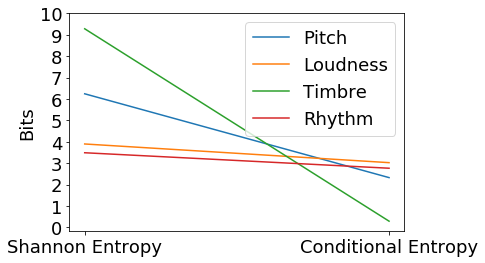

In [9]:
#graph differences between entropy and conditional entropy
plt.plot([means['shannon'][0],means['conditional'][0]],label='Pitch')
plt.plot([means['shannon'][1],means['conditional'][1]],label='Loudness')
plt.plot([means['shannon'][2],means['conditional'][2]],label='Timbre')
plt.plot([means['shannon'][3],means['conditional'][3]],label='Rhythm')
#x=range(4)
#plt.xticks(x,['Pitch','Loudness','Timbre','Rhythm'])
x=range(2)
plt.xticks(x,['Shannon Entropy','Conditional Entropy'])  
plt.yticks(range(11))
plt.legend()
plt.ylabel("Bits")
#plt.title("Reduction in Entropy based on Prior Knowledge")
plt.show()

In [10]:
#check year distributions
years_bb={}
for song in bb:
    years_bb.setdefault(song.year,0)
    years_bb[song.year]+=1

years={}
for song in allsongs:
    years.setdefault(song.year,0)
    years[song.year]+=1
print(len(years),len(years_bb))

90 57


5930.0 458789.0


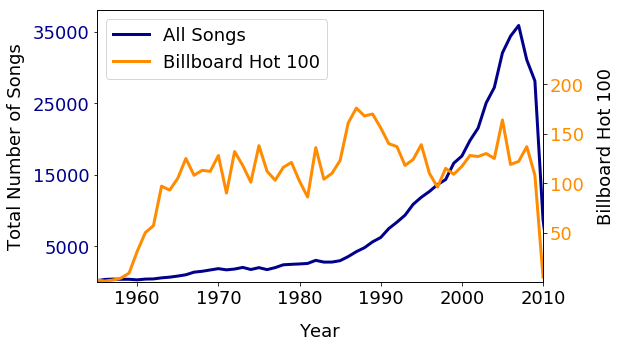

In [11]:
#plot distribution; notice how billboard hot 100 peaks in the late 80s
length1,length2=0.0,0.0
for song in bb:
    if song.year!=0: length1+=1
for song in allsongs:
    if song.year!=0: length2+=1

print(length1,length2)
fig, ax1 = plt.subplots(figsize=(8,5))
#proportions, divide by length2, length1 respectively
ln1=ax1.plot([x for x in sorted(years) if x!=0],[years[x]/1 for x in sorted(years) if x!=0],label='All Songs',
             color='darkblue',zorder=3,linewidth=3) #color='#0000CC'
ax2 = ax1.twinx()
ln2=ax2.plot([x for x in sorted(years_bb) if x!=0],[years_bb[x]/1 for x in sorted(years_bb) if x!=0],label='Billboard Hot 100',
         color='darkorange',zorder=2,linewidth=3) #'#CC8400'

ax1.set_xlim([1955,2010])
ax1.set_ylim([0,38000])
ax2.set_ylim([0,275])
ax1.set_yticks([5000,15000,25000,35000])
ax2.set_yticks([50,100,150,200])
ax1.set_xlabel('Year')
ax1.xaxis.set_label_coords(.5, -0.15)
ax1.set_ylabel('Total Number of Songs')
ax1.yaxis.set_label_coords(-.16, 0.5)
ax2.set_ylabel('Billboard Hot 100')
ax2.yaxis.set_label_coords(1.12, 0.5)
ax1.tick_params(axis='y', labelcolor='darkblue')
ax2.tick_params(axis='y', labelcolor='darkorange')
#plt.title('Proportion of Data over Time')
#plt.legend(loc='upper left')
#legend with two axes
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
#plt.savefig('music_complexity/Figures/number_over_time_all_mauch_doubleaxis.pdf',dpi=300,bbox_inches = "tight")

In [12]:
#describe number of Hot 100 songs per year, should cut out bad years in analysis
bad_years=[0,1955,1956,1957,1958,1959,2010]
total=sum([years_bb[year] for year in years_bb if year not in bad_years])
print("mean number per year: ",total/(len(years_bb)-len(bad_years))), #total/50
print(years_bb)

mean number per year:  118.14
{1991: 140, 0: 731, 1999: 109, 1976: 112, 1961: 50, 1988: 168, 1975: 138, 2003: 130, 1992: 137, 2009: 108, 1977: 103, 2001: 128, 1996: 110, 1963: 97, 1990: 156, 1960: 31, 1987: 176, 1986: 161, 1962: 57, 1998: 115, 1969: 112, 1966: 125, 1972: 132, 1971: 90, 1997: 96, 1974: 101, 1985: 123, 1980: 102, 1982: 136, 1970: 128, 2006: 119, 1979: 121, 2002: 127, 1964: 93, 1989: 170, 1967: 108, 1968: 113, 1993: 118, 2004: 125, 1978: 116, 2008: 137, 2005: 164, 1973: 118, 1994: 124, 1995: 139, 2007: 122, 1984: 110, 2000: 117, 1965: 105, 1983: 104, 1981: 86, 2010: 5, 1959: 9, 1958: 4, 1956: 1, 1955: 2, 1957: 2}


### Complexity and Popularity

In [13]:
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import pandas as pd
import scipy.stats

In [14]:
#http://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
#takes data array and returns mean, lower bound, and upper bound
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

In [15]:
#totals for Hot 100 and all
#pitch
arr=[song.pconEntropy for song in allsongs if song.pentropy]
print('all pconEntropy',np.mean(arr),np.std(arr),len(arr))
arr=[song.pconEntropy for song in bb if song.pentropy]
print('bb pconEntropy',np.mean(arr),np.std(arr),len(arr))
#loudness
arr=[song.lconEntropy for song in allsongs if song.lentropy]
print('all lconEntropy',np.mean(arr),np.std(arr),len(arr))
arr=[song.lconEntropy for song in bb if song.lentropy]
print('bb lconEntropy',np.mean(arr),np.std(arr),len(arr))
#timbre
arr=[song.tconEntropy for song in allsongs if song.tentropy]
print('all tconEntropy',np.mean(arr),np.std(arr),len(arr))
arr=[song.tconEntropy for song in bb if song.tentropy]
print('bb tconEntropy',np.mean(arr),np.std(arr),len(arr))
#rhythm
arr=[song.rconEntropy for song in allsongs if song.rentropy]
print('all rconEntropy',np.mean(arr),np.std(arr),len(arr))
arr=[song.rconEntropy for song in bb if song.rentropy]
print('bb rconEntropy',np.mean(arr),np.std(arr),len(arr))

all pconEntropy 2.3277115824488557 0.4666098230817166 905880
bb pconEntropy 2.3144186770235713 0.3431647055520651 6661
all lconEntropy 3.0264164928662427 0.43793641581244813 905893
bb lconEntropy 3.1079406128616567 0.29360593947270014 6661
all tconEntropy 0.2925135819004942 0.31111690377303053 905896
bb tconEntropy 0.1514933114614396 0.1359135689208456 6661
all rconEntropy 2.7660569460856768 0.5273281306005797 903300
bb rconEntropy 2.754019017867729 0.4277638319711727 6657


In [16]:
min_year=-1 #1959
subsample={song for song in allsongs if song.year>min_year}
print(len(subsample))

905896


In [22]:
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Mean	Variance
Hot 100:  2.702086773757694 0.18783380781335654
Average Random Sample:  2.71582175495186 0.2788015699480132
(2.71582175495186, 2.715408395550586, 2.7162351143531343) (0.2788015699480132, 0.2784431391357705, 0.2791600007602559)
Hot 100 Random Sample:  2.7037103800510733 0.18355691056222595
(2.7037103800510733, 2.7037103800510733, 2.7037103800510733) (0.18355691056222595, 0.18355691056222595, 0.18355691056222595)
Random sample length:  6657


Text(0.5, 1.05, 'Rhythm')

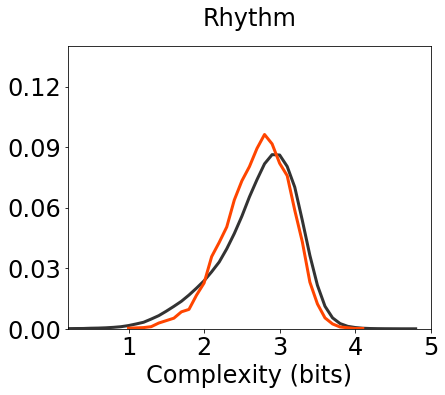

In [24]:
#collective U, bb is a little more narrow than overall distribution
from collections import Counter
from matplotlib.ticker import FormatStrFormatter
min_year=-1 #1959 #only count years with enough data
entropy_bins=[]
all_bins=[]
fig, ax1 = plt.subplots(figsize=(6.5,5.2))
print("Mean\tVariance")
#Hot 100
for song in bb:
    try:
        if song.year > min_year:
            entropy_bins.append(int(song.rconEntropy*10)/10.0) #specify entropy type #*50/50.0 for timbre (bins of .02)
    except: print(song.aname,song.title)
print("Hot 100: ",np.mean(entropy_bins),np.std(entropy_bins)**2)
#print(mean_confidence_interval(entropy_bins))
entropy_bins_cnt=Counter(entropy_bins).items()
entropy_bins_cnt=sorted(entropy_bins_cnt,key=lambda x: x[0])
xvalues=[x[0] for x in entropy_bins_cnt]
yvalues=[x[1]/float(len(bb)) for x in entropy_bins_cnt] #normalized
#plt.plot(xvalues,yvalues,label="Billboard Hot 100",color='#CC0000')

#all bins
for song in subsample:
    try:
        if song.year > min_year:
            all_bins.append(int(song.rconEntropy*10)/10.0) #specify entropy type
    except: pass
#print("All: ",np.mean(all_bins),np.std(all_bins)**2)
all_bins_cnt=Counter(all_bins).items()
all_bins_cnt=sorted(all_bins_cnt,key=lambda x: x[0])
xvalues=[x[0] for x in all_bins_cnt]
yvalues=[x[1]/float(len(allsongs)) for x in all_bins_cnt]
#plt.plot(xvalues,yvalues,label="All Songs",color='#0000CC')

#bootstrap random sample
samples=1000
rmeans,rstds=[],[]
rdic={}
for i in range(samples):
    rbins=rnd.sample(subsample,len(bb)) #create a random sample the same size as gbins, use subsample to be year selective
    rbins=[int(song.rconEntropy*10)/10.0 for song in rbins if song.rentropy>0] #specify entropy type
    rmeans.append(np.mean(rbins))
    rstds.append(np.std(rbins)**2) #variance
    all_rbins=Counter(rbins).items()
    for k in all_rbins:
        rdic.setdefault(k[0],0)
        rdic[k[0]]+=k[1]
rdic={k:rdic[k]/samples for k in rdic}

print("Average Random Sample: ",np.mean(rmeans),np.mean(rstds))
ci_rmean, ci_rstd = mean_confidence_interval(rmeans),mean_confidence_interval(rstds) #95% CI
print(ci_rmean, ci_rstd)
#print("Random sample length: ",len(rbins))
all_rbins=[(k,rdic[k]) for k in sorted(rdic)] #use to show average random sample
xvalues=[x[0] for x in all_rbins]
yvalues=[x[1]/float(len(bb)) for x in all_rbins] #normalized
plt.plot(xvalues,yvalues,label="Random\nSample",color='0.2',linewidth=3) #'#CC8400',linewidth=2

#bootstrap bb sample
samples=1000
rmeans,rstds=[],[]
rdic={}
for i in range(samples):
    rbins=rnd.sample(bb,len(bb)) #create a random sample the same size as gbins from bb
    rbins=[int(song.rconEntropy*10)/10.0 for song in rbins if song.rentropy>0] #specify entropy type
    rmeans.append(np.mean(rbins))
    rstds.append(np.std(rbins)**2)
    all_rbins=Counter(rbins).items()
    for k in all_rbins:
        rdic.setdefault(k[0],0)
        rdic[k[0]]+=k[1]
rdic={k:rdic[k]/samples for k in rdic}

print("Hot 100 Random Sample: ",np.mean(rmeans),np.mean(rstds))
ci_rmean_bb, ci_rstd_bb = mean_confidence_interval(rmeans),mean_confidence_interval(rstds) #95% CI
print(ci_rmean_bb, ci_rstd_bb)
print("Random sample length: ",len(rbins))
all_rbins=[(k,rdic[k]) for k in sorted(rdic)] #use to show average random sample
xvalues=[x[0] for x in all_rbins]
yvalues=[x[1]/float(len(bb)) for x in all_rbins] #normalized
plt.plot(xvalues,yvalues,label="Hot\n100",color='orangered',linewidth=3) #'#CC0000',linewidth=2

#plt.xlim([0,1.5]) #visualization for timbre only
#plt.xlim([-1,1.5]) #visualization for combined only
#plt.xlim([0.1,5]) #pitch
#plt.xlim([.9,4.9]) #loudness
plt.xlim([.2,5]) #rhythm
#plt.ylim([0,0.14]) #pitch
#plt.ylim([0,.14]) #loudness
#plt.ylim([0,.45]) #timbre
#plt.ylim([0,.14]) #timbre alternative for bins of .02
plt.ylim([0,.14]) #rhythm
ax1.set_xticks([1,2,3,4,5]) #loudness, pitch, rhythm
#ax1.set_xticks([.1,.4,.7,1.0,1.3]) #timbre
ax1.set_yticks([0,.03,.06,.09,.12]) #timbre, loudness, pitch, rhythm
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel("Complexity (bits)",) #fontsize=12
ax1.yaxis.set_label_coords(-0.2, 0.5)
#plt.ylabel("Proportion of Songs",) #fontsize=12

plt.title("Rhythm",y=1.05,) #specify entropy type, fontsize=20
#plt.legend(loc=1,) #fontsize=10
#plt.savefig('music_complexity/rhythm_complexity_bins_ylabel_new.pdf',dpi=300,bbox_inches = "tight") #specify complexity type

In [25]:
SMALL_SIZE = 28
MEDIUM_SIZE = 32
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Hot 100 Random Sample:  2.75427829431693 0.1827005179003396
(2.75427829431693, 2.7535096705686857, 2.7550469180651747) (0.1827005179003396, 0.1822119638304473, 0.18318907197023188)
Average Random Sample:  2.766786336372326 0.2772748587578867
(2.766786336372326, 2.7657250478390853, 2.767847624905567) (0.2772748587578867, 0.27635852292810403, 0.2781911945876694)
pop :  2.7515364816389867 0.23011772931357366
(2.7515364816389867, 2.7508339568054647, 2.7522390064725086) (0.23011772931357366, 0.22962416315546452, 0.2306112954716828)
hip hop :  2.79444557371299 0.23227906939617987
(2.79444557371299, 2.793547686390685, 2.795343461035295) (0.23227906939617987, 0.23147316613036956, 0.2330849726619902)
jazz :  3.088400119993045 0.19879057583741774
(3.088400119993045, 3.0876223627524713, 3.0891778772336185) (0.19879057583741774, 0.1980318804330566, 0.19954927124177887)
heavy metal :  2.9958871328294716 0.14952715348420556
(2.9958871328294716, 2.995172324214094, 2.9966019414448493) (0.1495271534842

Text(0.5, 0, 'Variance')

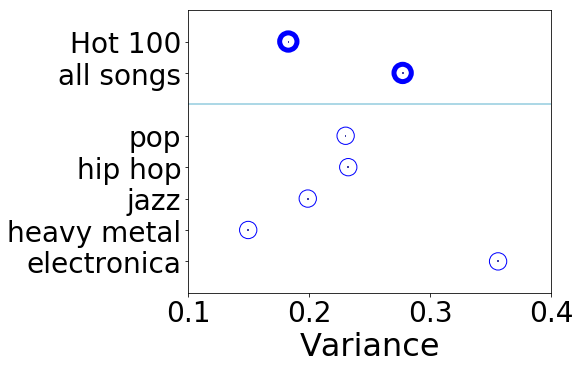

In [96]:
#find variance CIs by bootstrapping samples
top_genres=['pop','hip hop','jazz','heavy metal','electronica']
sample_length=1000 #length of each sample
samples=1000
xvalues=[] #holds the variances
yvalues=['Hot 100','all songs','','pop','hip hop','jazz','heavy metal','electronica']
lowers,uppers=[],[] #for CIs
fig, ax = plt.subplots(figsize=(6.5,5.2))

#bb sample
rmeans,rstds=[],[]
for i in range(samples):
    rbins=rnd.sample(bb,sample_length) 
    rbins=[song.rconEntropy for song in rbins if song.rentropy>0] #specify entropy type
    rmeans.append(np.mean(rbins))
    rstds.append(np.std(rbins)**2)

print("Hot 100 Random Sample: ",np.mean(rmeans),np.mean(rstds))
ci_rmean, ci_rstd = mean_confidence_interval(rmeans),mean_confidence_interval(rstds) #95% CI
print(ci_rmean, ci_rstd)
#print("Random sample length: ",len(rbins))
xvalues.append(np.mean(rstds))
lowers.append(abs(ci_rstd[1]-ci_rstd[0]))
uppers.append(abs(ci_rstd[2]-ci_rstd[0]))

#random sample
rmeans,rstds=[],[]
for i in range(samples):
    rbins=rnd.sample(allsongs,sample_length) #use subsample to be year selective
    rbins=[song.rconEntropy for song in rbins if song.rentropy>0] #specify entropy type
    rmeans.append(np.mean(rbins))
    rstds.append(np.std(rbins)**2) #variance

print("Average Random Sample: ",np.mean(rmeans),np.mean(rstds))
ci_rmean, ci_rstd = mean_confidence_interval(rmeans),mean_confidence_interval(rstds) #95% CI
print(ci_rmean, ci_rstd)
#print("Random sample length: ",len(rbins))
xvalues.append(np.mean(rstds))
lowers.append(abs(ci_rstd[1]-ci_rstd[0]))
uppers.append(abs(ci_rstd[2]-ci_rstd[0]))

xvalues.append(0) #our dummy value
lowers.append(0)
uppers.append(0)

#select genres
for genre in top_genres:
    rmeans,rstds=[],[]
    for i in range(samples):
        rbins=rnd.sample(genres[genre],sample_length) 
        rbins=[song.rconEntropy for song in rbins if song.rentropy>0] #specify entropy type
        rmeans.append(np.mean(rbins))
        rstds.append(np.std(rbins)**2)

    print(genre,": ",np.mean(rmeans),np.mean(rstds))
    ci_rmean, ci_rstd = mean_confidence_interval(rmeans),mean_confidence_interval(rstds) #95% CI
    print(ci_rmean, ci_rstd)
    #print("Random sample length: ",len(rbins))
    xvalues.append(np.mean(rstds))
    lowers.append(abs(ci_rstd[1]-ci_rstd[0]))
    uppers.append(abs(ci_rstd[2]-ci_rstd[0]))
    
yvalues.reverse() #display top-bottom
xvalues.reverse()
lowers.reverse()
uppers.reverse()
plt.scatter(xvalues,yvalues,s=[300,300,300,300,300,0,300,300],edgecolors='blue',marker='o',facecolors='none',
            linewidths=[1,1,1,1,1,0,5,5])
plt.errorbar(xvalues,yvalues,xerr=[lowers,uppers],color='darkblue',ls='none')
plt.yticks([0,1,2,3,4,6,7],['electronica','heavy metal','jazz','hip hop','pop','all songs','Hot 100'])
plt.ylim([-1,8])
ax.axhline(y=5, color='lightblue', linewidth=2)
#plt.xlim([0.08,0.33]) #pitch
#plt.xlim([0.05,.3]) #loudness
#plt.xlim([0,.2]) #timbre
plt.xlim([.1,.4]) #rhythm
#plt.xticks([.1,.2,.3]) #pitch,loudness
#plt.xticks([0,.1,.2]) #timbre
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.xlabel("Variance")
#plt.ylabel("Complexity (bits)")
#plt.title("Pitch",y=1.05) #specify entropy type
#plt.legend(loc=1,fontsize=10)
#plt.savefig('music_complexity/Figures/rhythm_complexity_variances.pdf',dpi=300,bbox_inches = "tight") #specify

### Complexity Across Time

In [26]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

All songs regression line:  [0.00082089 0.66805016]
Hot 100 regression line:  [ 5.09022271e-03 -7.78944900e+00]


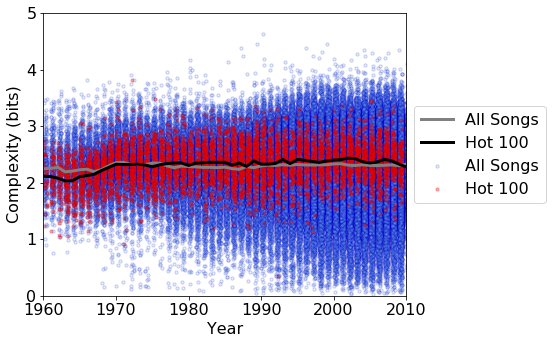

In [27]:
#track pitch entropy over time
import random
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
nonlinear_fit=False
min_year=1959
plt.figure(figsize=(6.5,5.2))

xvalues=[song.year + random.uniform(0,.5) for song in allsongs if (song.year>1900 and song.pconEntropy>0)]
yvalues=[song.pconEntropy for song in allsongs if (song.year>1900 and song.pconEntropy>0)]
plt.scatter(xvalues,yvalues,facecolors='skyblue',edgecolor='#0000CC',label='All Songs',
            linewidths=1,alpha=.2,s=10)#,lw=0.5)
#compare with billboard Hot 100
xbbvalues=[song.year + random.uniform(0,.5) for song in bb if (song.year>min_year and song.pconEntropy>0)]
ybbvalues=[song.pconEntropy for song in bb if (song.year>min_year and song.pconEntropy>0)]
plt.scatter(xbbvalues,ybbvalues,facecolors='red',edgecolor='#CC0000',label='Hot 100',
            linewidths=1,alpha=.3,s=10,marker='o')#,lw=0.5)
plt.xlim(1960,2010)
plt.ylabel("Complexity (bits)")
plt.xlabel("Year")
#plt.title("Change of Pitch Complexity over Time")
fit= np.polyfit(xvalues, yvalues, 1)
fit_fn = np.poly1d(fit)
fitbb=np.polyfit(xbbvalues,ybbvalues,1)
fitbb_fn=np.poly1d(fitbb)

if nonlinear_fit:
    lw=lowess(yvalues,xvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw],[x[1] for x in lw],color='grey',label='All Songs')
    lw_bb=lowess(ybbvalues,xbbvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw_bb],[x[1] for x in lw_bb],color='black',label='Hot 100')
else:  
    #plt.plot(xvalues, fit_fn(xvalues), '-',color='grey',label='All Songs') #m*xvalues + b
    #plt.plot(xbbvalues,fitbb_fn(xbbvalues),'-',color='black',label='Hot 100')
    #plt.plot(xbbvalues,[fit[0]*x + fit[1] for x in xbbvalues],'*',color='green') #double-check fit
    #alternatively, plot means
    years=[year for year in range(1960,2011)]
    allmeans=[np.mean([song.pconEntropy for song in allsongs if song.year==year]) for year in years]
    bbmeans=[np.mean([song.pconEntropy for song in bb if song.year==year]) for year in years]
    plt.plot(years,allmeans,'-',color='grey',label='All Songs',linewidth=3)
    plt.plot(years,bbmeans,'-',color='black',label='Hot 100',linewidth=3)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-0.0,5])
print("All songs regression line: ",fit) #indexed [slope, y-intercept]
print("Hot 100 regression line: ",fitbb)

In [29]:
#find outliers for pitch
from collections import Counter
gterms=[]
for genre in genres:
    for song in genres[genre]:
        if song.pconEntropy < means['conditional'][0] - 3*math.sqrt(variances['conditional'][0]):
            gterms.append(song.terms)
print(Counter(gterms).most_common(10))

[('grindcore', 759), ('hip hop', 467), ('hardcore punk', 267), ('noise rock', 179), ('experimental rock', 135), ('rock', 129), ('garage rock', 128), ('free improvisation', 122), ('gangster rap', 119), ('tech house', 115)]


All songs regression line:  [-4.86598055e-03  1.27206773e+01]
Hot 100 regression line:  [0.00126663 0.59354501]


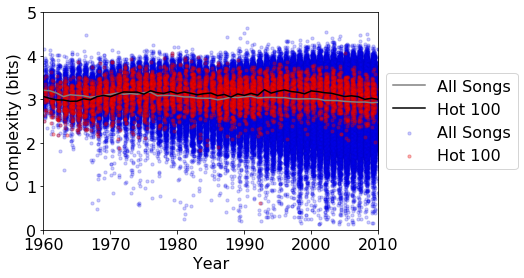

In [71]:
#track loudness entropy over time
import random
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
nonlinear_fit=False
min_year=1959

xvalues=[song.year + random.uniform(0,.5) for song in allsongs if (song.year>1900 and song.lconEntropy>0)]
yvalues=[song.lconEntropy for song in allsongs if (song.year>1900 and song.lconEntropy>0)]
plt.scatter(xvalues,yvalues,facecolors='blue',edgecolor='#0000CC',label='All Songs',
            linewidths=1,alpha=.2,s=10)#,lw=0.5)
#compare with billboard Hot 100
xbbvalues=[song.year + random.uniform(0,.5) for song in bb if (song.year>min_year and song.lconEntropy>0)]
ybbvalues=[song.lconEntropy for song in bb if (song.year>min_year and song.lconEntropy>0)]
plt.scatter(xbbvalues,ybbvalues,facecolors='red',edgecolor='#CC0000',label='Hot 100',
            linewidths=1,alpha=.3,s=10,marker='o')#,lw=0.5)
plt.xlim(1960,2010)
plt.ylabel("Complexity (bits)")
plt.xlabel("Year")
#plt.title("Change of Loudness Complexity over Time")
fit= np.polyfit(xvalues, yvalues, 1)
fit_fn = np.poly1d(fit)
fitbb=np.polyfit(xbbvalues,ybbvalues,1)
fitbb_fn=np.poly1d(fitbb)

if nonlinear_fit:
    lw=lowess(yvalues,xvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw],[x[1] for x in lw],color='grey',label='All Songs')
    lw_bb=lowess(ybbvalues,xbbvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw_bb],[x[1] for x in lw_bb],color='black',label='Hot 100')
else:  
    #plt.plot(xvalues, fit_fn(xvalues), '-',color='grey',label='All Songs') #m*xvalues + b
    #plt.plot(xbbvalues,fitbb_fn(xbbvalues),'-',color='black',label='Hot 100')
    #plt.plot(xbbvalues,[fit[0]*x + fit[1] for x in xbbvalues],'*',color='green') #double-check fit
    #alternatively, plot means
    years=[year for year in range(1960,2011)]
    allmeans=[np.mean([song.lconEntropy for song in allsongs if song.year==year]) for year in years]
    bbmeans=[np.mean([song.lconEntropy for song in bb if song.year==year]) for year in years]
    plt.plot(years,allmeans,'-',color='grey',label='All Songs')
    plt.plot(years,bbmeans,'-',color='black',label='Hot 100')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-0.0,5])
print("All songs regression line: ",fit) #indexed [slope, y-intercept]
print("Hot 100 regression line: ",fitbb)
plt.show()

In [30]:
#find outliers for loudness
from collections import Counter
gterms=[]
for genre in genres:
    for song in genres[genre]:
        if song.lconEntropy < means['conditional'][1] - 3*math.sqrt(variances['conditional'][1]):
            gterms.append(song.terms)
print(Counter(gterms).most_common(10))

[('grindcore', 393), ('hip hop', 251), ('black metal', 230), ('garage rock', 159), ('soundtrack', 148), ('indie rock', 143), ('experimental rock', 140), ('noise rock', 132), ('folk rock', 118), ('speed metal', 115)]


All songs regression line:  [ 2.42877166e-03 -4.57423965e+00]
Hot 100 regression line:  [ 1.18853130e-03 -2.20907802e+00]


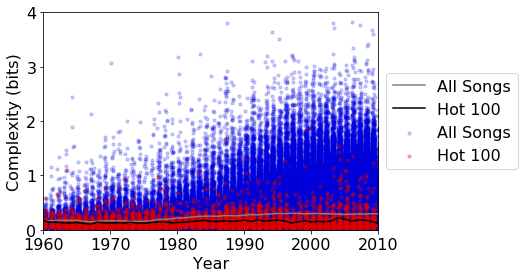

In [74]:
#track timbre entropy over time
import random
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
nonlinear_fit=False
min_year=1959

xvalues=[song.year + random.uniform(0,.5) for song in allsongs if (song.year>1900 and song.tconEntropy>0)]
yvalues=[song.tconEntropy for song in allsongs if (song.year>1900 and song.tconEntropy>0)]
plt.scatter(xvalues,yvalues,facecolors='blue',edgecolor='#0000CC',label='All Songs',
            linewidths=1,alpha=.2,s=10)#,lw=0.5)
#compare with billboard Hot 100
xbbvalues=[song.year + random.uniform(0,.5) for song in bb if (song.year>min_year and song.tconEntropy>0)]
ybbvalues=[song.tconEntropy for song in bb if (song.year>min_year and song.tconEntropy>0)]
plt.scatter(xbbvalues,ybbvalues,facecolors='red',edgecolor='#CC0000',label='Hot 100',
            linewidths=1,alpha=.3,s=10,marker='o')#,lw=0.5)
plt.xlim(1960,2010)
plt.ylabel("Complexity (bits)")
plt.xlabel("Year")
#plt.title("Change of Timbre Complexity over Time")
fit= np.polyfit(xvalues, yvalues, 1)
fit_fn = np.poly1d(fit)
fitbb=np.polyfit(xbbvalues,ybbvalues,1)
fitbb_fn=np.poly1d(fitbb)

if nonlinear_fit:
    lw=lowess(yvalues,xvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw],[x[1] for x in lw],color='grey',label='All Songs')
    lw_bb=lowess(ybbvalues,xbbvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw_bb],[x[1] for x in lw_bb],color='black',label='Hot 100')
else:  
    #plt.plot(xvalues, fit_fn(xvalues), '-',color='grey',label='All Songs') #m*xvalues + b
    #plt.plot(xbbvalues,fitbb_fn(xbbvalues),'-',color='black',label='Hot 100')
    #plt.plot(xbbvalues,[fit[0]*x + fit[1] for x in xbbvalues],'*',color='green') #double-check fit
    #alternatively, plot means
    years=[year for year in range(1960,2011)]
    allmeans=[np.mean([song.tconEntropy for song in allsongs if song.year==year]) for year in years]
    bbmeans=[np.mean([song.tconEntropy for song in bb if song.year==year]) for year in years]
    plt.plot(years,allmeans,'-',color='grey',label='All Songs')
    plt.plot(years,bbmeans,'-',color='black',label='Hot 100')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-0.0,4])
print("All songs regression line: ",fit) #indexed [slope, y-intercept]
print("Hot 100 regression line: ",fitbb)
plt.show()

In [31]:
#find (positive or negative) outliers for timbre
from collections import Counter
gterms=[]
for genre in genres:
    for song in genres[genre]:
        if song.tconEntropy > means['conditional'][2] + 3*math.sqrt(variances['conditional'][2]):
            gterms.append(song.terms)
print(Counter(gterms).most_common(10))

[('tech house', 3316), ('techno', 1359), ('deep house', 906), ('hard trance', 818), ('progressive house', 543), ('progressive trance', 504), ('hip hop', 419), ('jungle music', 388), ('black metal', 383), ('glitch', 325)]


All songs regression line:  [-2.64011737e-03  8.05371756e+00]
Hot 100 regression line:  [-9.27209554e-04  4.59101505e+00]


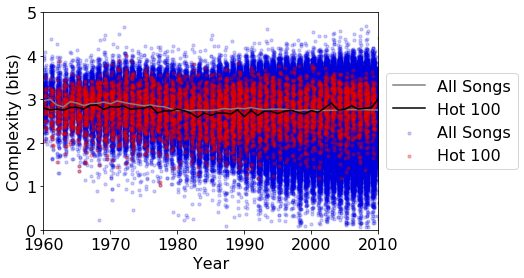

In [77]:
#track rhythm entropy over time
import random
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
nonlinear_fit=False
min_year=1959

xvalues=[song.year + random.uniform(0,.5) for song in allsongs if (song.year>1900 and song.rconEntropy>0)]
yvalues=[song.rconEntropy for song in allsongs if (song.year>1900 and song.rconEntropy>0)]
plt.scatter(xvalues,yvalues,facecolors='blue',edgecolor='#0000CC',label='All Songs',
            linewidths=1,alpha=.2,s=10)#,lw=0.5)
#compare with billboard Hot 100
xbbvalues=[song.year + random.uniform(0,.5) for song in bb if (song.year>min_year and song.rconEntropy>0)]
ybbvalues=[song.rconEntropy for song in bb if (song.year>min_year and song.rconEntropy>0)]
plt.scatter(xbbvalues,ybbvalues,facecolors='red',edgecolor='#CC0000',label='Hot 100',
            linewidths=1,alpha=.3,s=10,marker='o')#,lw=0.5)
plt.xlim(1960,2010)
plt.ylabel("Complexity (bits)")
plt.xlabel("Year")
#plt.title("Change of Rhythm Complexity over Time")
fit= np.polyfit(xvalues, yvalues, 1)
fit_fn = np.poly1d(fit)
fitbb=np.polyfit(xbbvalues,ybbvalues,1)
fitbb_fn=np.poly1d(fitbb)

if nonlinear_fit:
    lw=lowess(yvalues,xvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw],[x[1] for x in lw],color='grey',label='All Songs')
    lw_bb=lowess(ybbvalues,xbbvalues,is_sorted=False,return_sorted=True)
    plt.plot([x[0] for x in lw_bb],[x[1] for x in lw_bb],color='black',label='Hot 100')
else:  
    #plt.plot(xvalues, fit_fn(xvalues), '-',color='grey',label='All Songs') #m*xvalues + b
    #plt.plot(xbbvalues,fitbb_fn(xbbvalues),'-',color='black',label='Hot 100')
    #plt.plot(xbbvalues,[fit[0]*x + fit[1] for x in xbbvalues],'*',color='green') #double-check fit
    #alternatively, plot means
    years=[year for year in range(1960,2011)]
    allmeans=[np.mean([song.rconEntropy for song in allsongs if song.year==year]) for year in years]
    bbmeans=[np.mean([song.rconEntropy for song in bb if song.year==year]) for year in years]
    plt.plot(years,allmeans,'-',color='grey',label='All Songs')
    plt.plot(years,bbmeans,'-',color='black',label='Hot 100')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-0.0,5])
print("All songs regression line: ",fit) #indexed [slope, y-intercept]
print("Hot 100 regression line: ",fitbb)
plt.show()

In [32]:
#find outliers for rhythm
from collections import Counter
gterms=[]
for genre in genres:
    for song in genres[genre]:
        if song.rconEntropy < means['conditional'][3] - 3*math.sqrt(variances['conditional'][3]):
            gterms.append(song.terms)
print(Counter(gterms).most_common(10))

[('tech house', 896), ('techno', 374), ('hard trance', 323), ('progressive house', 277), ('deep house', 271), ('future jazz', 214), ('electro', 213), ('progressive trance', 209), ('hip hop', 179), ('trip hop', 154)]


In [33]:
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [34]:
#record conditional entropy values more compactly, only iterate through songs once
all_entropies={'hot':{},'all':{}}
for song in bb:
    all_entropies['hot'].setdefault(song.year,{'pconEntropy':[],'lconEntropy':[],'tconEntropy':[],'rconEntropy':[]})
    if song.pentropy>0: 
        all_entropies['hot'][song.year]['pconEntropy'].append(song.pconEntropy)
    if song.lentropy>0: 
        all_entropies['hot'][song.year]['lconEntropy'].append(song.lconEntropy)
    if song.tentropy>0: 
        all_entropies['hot'][song.year]['tconEntropy'].append(song.tconEntropy)
    if song.rentropy>0: 
        all_entropies['hot'][song.year]['rconEntropy'].append(song.rconEntropy)

for song in allsongs:
    all_entropies['all'].setdefault(song.year,{'pconEntropy':[],'lconEntropy':[],'tconEntropy':[],'rconEntropy':[]})
    if song.pentropy>0: 
        all_entropies['all'][song.year]['pconEntropy'].append(song.pconEntropy)
    if song.lentropy>0: 
        all_entropies['all'][song.year]['lconEntropy'].append(song.lconEntropy)
    if song.tentropy>0: 
        all_entropies['all'][song.year]['tconEntropy'].append(song.tconEntropy)
    if song.rentropy>0: 
        all_entropies['all'][song.year]['rconEntropy'].append(song.rconEntropy)

print(len(all_entropies['hot']),len(all_entropies['all']))

57 90


C:\Anaconda\envs\python3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda\envs\python3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Pitch
All:  -0.014	 Hot 100:  -0.023
All:  0.003	 Hot 100:  0.013
All:  0.005	 Hot 100:  -0.003
All:  -0.000	 Hot 100:  -0.001
Loudness
All:  -0.034	 Hot 100:  -0.025
All:  -0.001	 Hot 100:  0.010
All:  0.006	 Hot 100:  -0.001
All:  -0.008	 Hot 100:  -0.009
Timbre
All:  0.005	 Hot 100:  -0.010
All:  0.004	 Hot 100:  0.001
All:  0.004	 Hot 100:  -0.000
All:  0.000	 Hot 100:  0.000
Rhythm
All:  -0.020	 Hot 100:  0.002
All:  -0.010	 Hot 100:  -0.009
All:  0.008	 Hot 100:  0.011
All:  -0.001	 Hot 100:  0.010


Text(0.5, 0.95, 'Complexity over time across features')

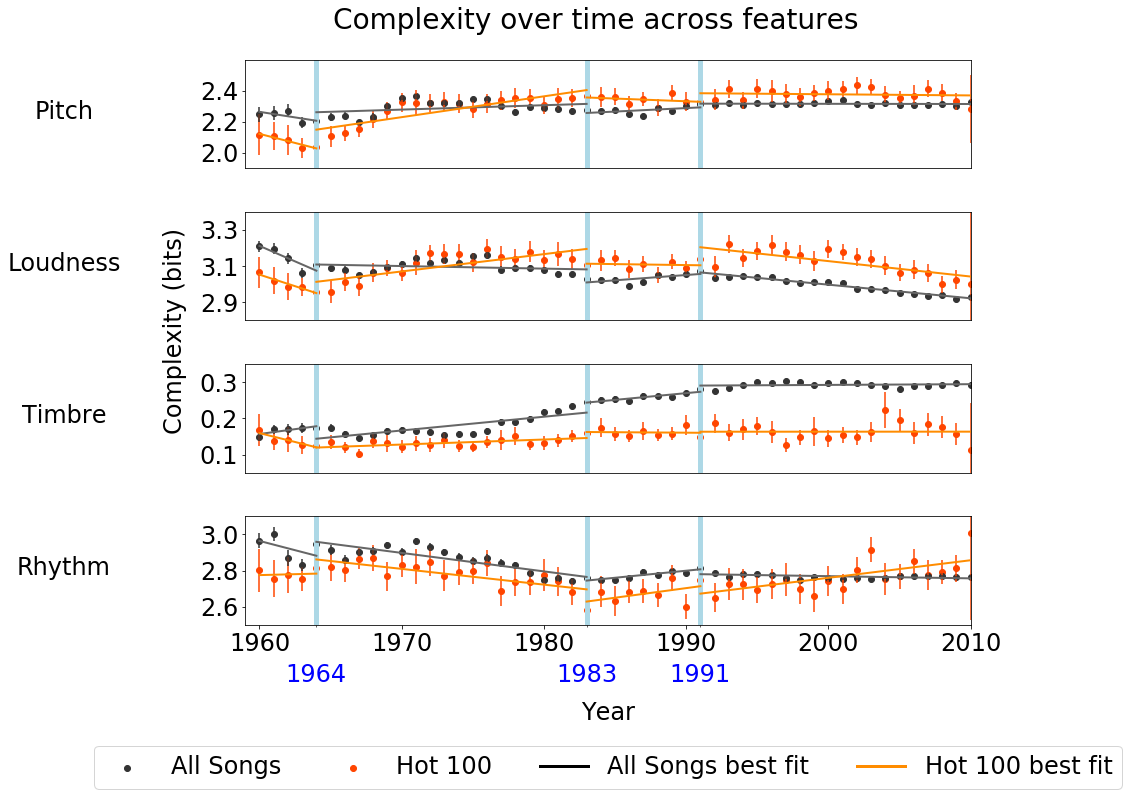

In [35]:
#create plot combining total/Hot 100 overtime with CIs, regression lines, and specified change points
from scipy.stats import ttest_ind
import statsmodels.api as sm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
lowess = sm.nonparametric.lowess
etypes=['pconEntropy','lconEntropy','tconEntropy','rconEntropy']
types={'pconEntropy':'Pitch','lconEntropy':'Loudness','tconEntropy':'Timbre','rconEntropy':'Rhythm'}
min_year=1959
max_year=2011
pt_regression=True
regression=False
#plot info
fig, ax = plt.subplots(len(etypes),1,figsize=(13,2.6*len(etypes))) #figsize=(7,5)

for r,etype in enumerate(etypes):
    xbbvalues=[year for year in sorted(years_bb) if year>min_year and year<max_year]
    ybbvalues=[np.mean(all_entropies['hot'][year][etype]) for year in xbbvalues]
    xvalues=[year for year in sorted(years) if year>min_year and year<max_year]
    yvalues=[np.mean(all_entropies['all'][year][etype]) for year in xvalues]
    lines_bb=ax[r].scatter(xbbvalues,ybbvalues,label='Billboard Hot 100',color='orangered') #'#CC0000'
    lines=ax[r].scatter(xvalues,yvalues,label='All Songs',color='0.2') #'#0000CC'
    #ax[r].set_xlabel('Year')
    #ax[r].set_ylabel('Complexity (bits)')
    ax[r].set_xlim([min_year,max_year-1])
    if etype=='pconEntropy':
        ax[r].set_ylim([1.9,2.6])
        ax[r].set_yticks([2,2.2,2.4])
    elif etype=='lconEntropy':
        ax[r].set_ylim([2.8,3.4])
        ax[r].set_yticks([2.9,3.1,3.3])
    elif etype=='tconEntropy':
        ax[r].set_ylim([0.05,0.35])
        ax[r].set_yticks([0.1,0.2,0.3])
    else:
        ax[r].set_ylim([2.5,3.1]) 
        ax[r].set_yticks([2.6,2.8,3.0])

    ci_bb, ci_all = mean_confidence_interval(ybbvalues),mean_confidence_interval(yvalues)
    #print(ci_bb, ci_all)
    #find error ranges
    bb_lowers=[abs(mean_confidence_interval(all_entropies['hot'][year][etype])[1] -
              mean_confidence_interval(all_entropies['hot'][year][etype])[0]) for year in xbbvalues]
    bb_uppers=[abs(mean_confidence_interval(all_entropies['hot'][year][etype])[2] -
               mean_confidence_interval(all_entropies['hot'][year][etype])[0]) for year in xbbvalues]
    all_lowers=[abs(mean_confidence_interval(all_entropies['all'][year][etype])[1] -
                    mean_confidence_interval(all_entropies['all'][year][etype])[0]) for year in xvalues]
    all_uppers=[abs(mean_confidence_interval(all_entropies['all'][year][etype])[2] -
                    mean_confidence_interval(all_entropies['all'][year][etype])[0]) for year in xvalues]

    ax[r].errorbar(xbbvalues,ybbvalues,yerr=[bb_lowers,bb_uppers],color='orangered',ls='none') #ls none for no connecting line
    ax[r].errorbar(xvalues,yvalues,yerr=[all_lowers,all_uppers],color='0.2',ls='none')

    #find deviations outside of CIs
    high_yrs=[year for year in sorted(years_bb) if mean_confidence_interval(all_entropies['hot'][year][etype])[1] >
              mean_confidence_interval(all_entropies['all'][year][etype])[2]]
    #print("Hot 100 significantly higher than overall distribution",high_yrs)
    low_yrs=[year for year in sorted(years_bb) if mean_confidence_interval(all_entropies['hot'][year][etype])[2] <
             mean_confidence_interval(all_entropies['all'][year][etype])[1]]
    #print("Hot 100 significantly lower than overall distribution",low_yrs)

    #alternatively, use Welch's unequal variances t-test, do NOT assume equal variances as we suspect Hot 100 is less varied
    diff_yrs=[year for year in xbbvalues if 
              ttest_ind(all_entropies['all'][year][etype],all_entropies['hot'][year][etype],equal_var=False)[1] < 0.05]
    high_yrs=[year for year in diff_yrs if np.mean(all_entropies['hot'][year][etype]) > np.mean(all_entropies['all'][year][etype])]
    #print("Hot 100 significantly higher than overall distribution",high_yrs)
    low_yrs=[year for year in diff_yrs if np.mean(all_entropies['hot'][year][etype]) < np.mean(all_entropies['all'][year][etype])]
    #print("Hot 100 significantly lower than overall distribution",low_yrs)
    '''
    #annotate statistical significance on graph (in terms of Hot 100 interval)
    for year in high_yrs:
        ax[r].annotate("*", xy=(year, mean_confidence_interval(all_entropies['hot'][year][etype])[2]),
                    xytext=(3,-5), textcoords='offset points', ha='center', va='bottom',)
    for year in low_yrs:
        ax[r].annotate("*", xy=(year, mean_confidence_interval(all_entropies['hot'][year][etype])[1]),
                    xytext=(3,-9), textcoords='offset points', ha='center', va='bottom',) '''

    #changepoints
    print(types[etype])
    bkps=[1964,1983,1991,2011]
    last_pt=min_year+1
    for pt in bkps:
        ax[r].axvline(x=pt, color='lightblue', linewidth=5)
        sub_years=xvalues[last_pt-min_year-1:pt-min_year]
        sub_scores=yvalues[last_pt-min_year-1:pt-min_year]
        sub_scores_bb=ybbvalues[last_pt-min_year-1:pt-min_year]
        last_pt=pt
        if pt_regression:
            fit=np.polyfit(sub_years, sub_scores, 1)
            fit_fn=np.poly1d(fit)
            ax[r].plot(sub_years, fit_fn(sub_years), '-',color='0.4',linewidth=2) #m*xvalues + b
            fitbb=np.polyfit(sub_years,sub_scores_bb,1)
            fitbb_fn=np.poly1d(fitbb)
            ax[r].plot(sub_years, fitbb_fn(sub_years), '-',color='darkorange',linewidth=2) #m*xvalues + b
            #print(sub_years,fit,fitbb)
            #annotate regression slope
            print("All:  %.3f\t" % fit[0],"Hot 100:  %.3f" % fitbb[0])
            #ax.annotate("m=%.01f" % fit[0], xy=(2006,fit_fn(2006)), xytext=(3,-20), textcoords='offset points', ha='center', va='bottom',)
            lw=lowess(sub_scores,sub_years,is_sorted=False,return_sorted=True)
            lw_bb=lowess(sub_scores_bb,sub_years,is_sorted=False,return_sorted=True)
            #ax[r].plot([x[0] for x in lw],[x[1] for x in lw],color='grey')
            #ax[r].plot([x[0] for x in lw_bb],[x[1] for x in lw_bb],color='black')
            
    #liner regression over whole range
    if regression:
        fit=np.polyfit(xvalues, yvalues, 1)
        fit_fn=np.poly1d(fit)
        #ax[r].plot(xvalues, fit_fn(xvalues), '-',color='grey',label='All Songs best fit') #m*xvalues + b
        fitbb=np.polyfit(xbbvalues,ybbvalues,1)
        fitbb_fn=np.poly1d(fitbb)
        #ax[r].plot(xbbvalues,fitbb_fn(xbbvalues),'-',color='black',label='Hot 100 best fit')
        print(fit,fitbb)
        #lowess
        lw=lowess(yvalues,xvalues,is_sorted=False,return_sorted=True)
        lw_bb=lowess(ybbvalues,xbbvalues,is_sorted=False,return_sorted=True)
        ax[r].plot([x[0] for x in lw],[x[1] for x in lw],color='grey',label='All Songs best fit')
        ax[r].plot([x[0] for x in lw_bb],[x[1] for x in lw_bb],color='black',label='Hot 100 best fit')
    
    ax[r].set_title(types[etype],x=-0.25,y=0.4)
    ax[r].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if r==len(etypes)-1:
        ax[r].set_xticks(bkps[:-1],minor=True)
        ax[r].set_xticklabels([1964,1983,1991],y=-.3,color='blue',minor=True)
        ax[r].set_xlabel('Year')
        ax[r].xaxis.set_label_coords(.5, -0.7)
        ax[r].set_ylabel('Complexity (bits)')
        ax[r].yaxis.set_label_coords(-0.08, 2.7)
    else:
        ax[r].set_xticks([])
    
grey_line = Line2D([], [], color='black', markersize=100, linewidth=3)
black_line = Line2D([], [], color='darkorange', markersize=100, linewidth=3)
plt.legend([lines,lines_bb,grey_line,black_line],['All Songs','Hot 100','All Songs best fit','Hot 100 best fit'],
           loc='upper center', bbox_to_anchor=(0.5, -1.0),
          fancybox=True, shadow=False, ncol=4) #bbox_to_anchor=(1, 0.5)
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Complexity over time across features", y=0.95)
#plt.savefig('music_complexity/Figures/complexity_overtime_with_epochs_labeled.pdf',dpi=300,bbox_inches = "tight")

### Complexity Across Genres

In [36]:
#most represented genres in the dataset
for genre in sorted(genres,key=lambda x: len(genres[x]), reverse=True): 
    if len(genres[genre])>10000:
        print(genre, len(genres[genre]))

hip hop 27903
pop rock 26110
blues-rock 17987
folk rock 17488
country rock 15718
tech house 14468
indie rock 11923
soft rock 11603
ballad 11434
chanson 10299
disco 10108
trip hop 10068


In [38]:
#get genre means
print(len(genres),'genres')
genre_means={}
genre_lengths={}
genre_variances={}
for genre in genres:
    genre_means[genre]={'pconEntropy':0,'lconEntropy':0,'tconEntropy':0,'rconEntropy':0}
    genre_lengths[genre]={'pconEntropy':0,'lconEntropy':0,'tconEntropy':0,'rconEntropy':0}
    genre_variances[genre]={'pconEntropy':0,'lconEntropy':0,'tconEntropy':0,'rconEntropy':0}
    pmeans=[song.pconEntropy for song in genres[genre] if song.pentropy>0]
    lmeans=[song.lconEntropy for song in genres[genre] if song.lentropy>0]
    tmeans=[song.tconEntropy for song in genres[genre] if song.tentropy>0]
    rmeans=[song.rconEntropy for song in genres[genre] if song.rentropy>0]
    #means
    genre_means[genre]['pconEntropy']=np.mean(pmeans)
    genre_means[genre]['lconEntropy']=np.mean(lmeans)
    genre_means[genre]['tconEntropy']=np.mean(tmeans)
    genre_means[genre]['rconEntropy']=np.mean(rmeans)
    #lengths
    genre_lengths[genre]['pconEntropy']=len(pmeans)
    genre_lengths[genre]['lconEntropy']=len(lmeans)
    genre_lengths[genre]['tconEntropy']=len(tmeans)
    genre_lengths[genre]['rconEntropy']=len(rmeans)
    #variances
    genre_variances[genre]['pconEntropy']=np.std(pmeans)**2
    genre_variances[genre]['lconEntropy']=np.std(lmeans)**2
    genre_variances[genre]['tconEntropy']=np.std(tmeans)**2
    genre_variances[genre]['rconEntropy']=np.std(rmeans)**2

758 genres


In [39]:
#look at top genres based on conditional entropy with variances
top_genres=['pop','hip hop','jazz','heavy metal','electronica']
etype='pconEntropy' #specify genre
for genre in sorted(genre_means,key=lambda x: genre_means[x][etype], reverse=True)[:100]: 
    if len(genres[genre])>1000: 
        print(genre,genre_means[genre][etype],genre_variances[genre][etype])

print(",".join(sorted(top_genres, key=lambda x: genre_means[x][etype], reverse=True))) #highest to lowest

progressive trance 2.7196568164650134 0.2528494205234031
trance 2.6968733077654923 0.20381545600461137
afrobeat 2.6953436096692474 0.23602826329242194
hard bop 2.6595698043378504 0.20980105678600222
salsa 2.653883108518407 0.1142834174724168
roots reggae 2.64707814937802 0.09182369573976733
bhangra 2.6377212395286103 0.13303608357640218
lovers rock 2.6343067473164945 0.10063787460146116
dancehall 2.6321854333527828 0.12065440687306371
merengue 2.6284982180170395 0.112646405132997
hip hop,jazz,electronica,pop,heavy metal


(0.7719538430460079, 2.1550171318113313e-43)


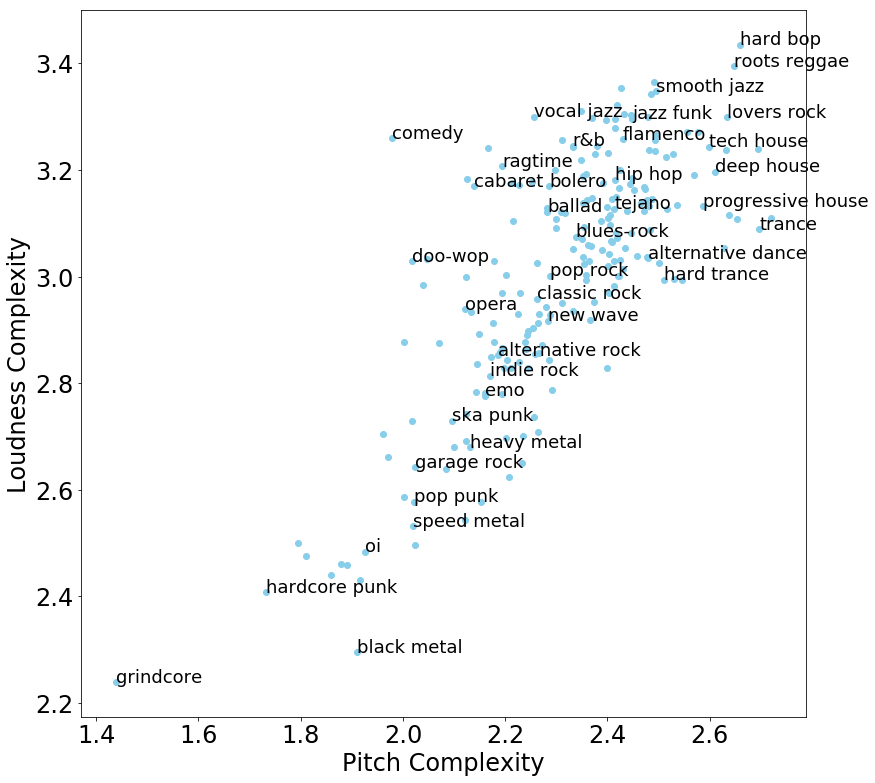

In [40]:
#visualize top genres based on feature scores, PITCH vs LOUDNESS; note the positive correlation ~.77
from scipy.stats.stats import pearsonr
top_genres=[g for g in genres if len(genres[g])>1000]
top_genres=sorted(top_genres,key=lambda x:len(genres[x]),reverse=True)
xval,yval='pitch','loudness' #features to plot
xvalues=[genre_means[g]['pconEntropy'] for g in top_genres]
yvalues=[genre_means[g]['lconEntropy'] for g in top_genres]
fig,ax=plt.subplots(figsize=(13,13))
ax.scatter(xvalues,yvalues,facecolors='skyblue',linewidths=1)
plt.xlabel("Pitch Complexity")
plt.ylabel("Loudness Complexity")
#plt.title("Pitch vs Loudness Complexity",y=1.05,fontsize=28)
ann=[]
for i,label in enumerate(top_genres):
    if len(genres[label])>1000: #only label largest genres
        ann.append(ax.annotate(label, (xvalues[i],yvalues[i]), fontsize=18))
print(pearsonr(xvalues,yvalues))

#add for non-overlapping labels, from https://stackoverflow.com/questions/25516325/non-overlapping-scatter-plot-labels-using-matplotlib
mask = np.zeros(fig.canvas.get_width_height(), bool)
fig.canvas.draw()
for a in ann:
    bbox = a.get_window_extent()
    x0 = int(bbox.x0)
    x1 = int(math.ceil(bbox.x1))
    y0 = int(bbox.y0)
    y1 = int(math.ceil(bbox.y1))

    s = np.s_[x0:x1+1, y0:y1+1]
    if np.any(mask[s]):
        a.set_visible(False)
    else:
        mask[s] = True
        
#plt.savefig('music_complexity/Figures/pitch_vs_loudness_by_genre_scarce_labels.pdf',dpi=300,bbox_inches = "tight")

(-0.5508145620404382, 2.6834311844875632e-18)


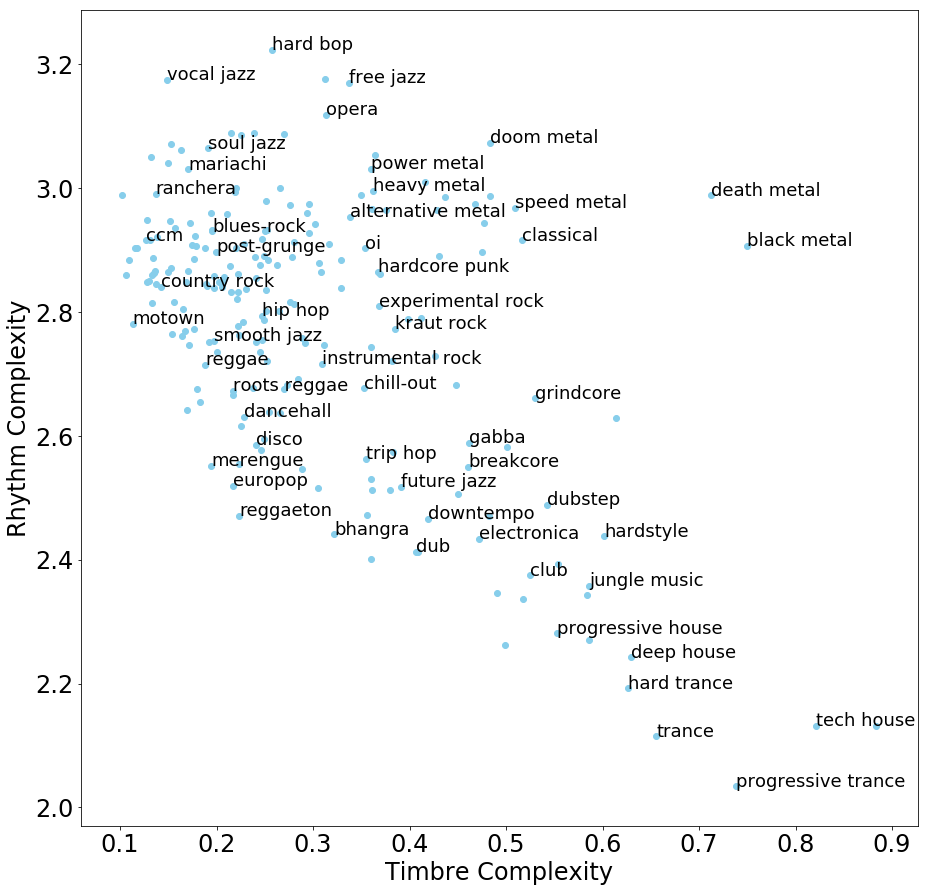

In [41]:
#visualize top genres based on feature scores, TIMBRE vs RHYTHM; note the negative correlation, ~-.55
from scipy.stats.stats import pearsonr
top_genres=[g for g in genres if len(genres[g])>1000]
top_genres=sorted(top_genres,key=lambda x:len(genres[x]),reverse=True)
xvalues=[genre_means[g]['tconEntropy'] for g in top_genres]
yvalues=[genre_means[g]['rconEntropy'] for g in top_genres]
fig,ax=plt.subplots(figsize=(15,15))
ax.scatter(xvalues,yvalues,facecolors='skyblue',linewidths=1)
plt.xlabel("Timbre Complexity")
plt.ylabel("Rhythm Complexity")
#plt.title("Timbre vs Rhythm Complexity", y=1.05,fontsize=28)
ann=[]
for i,label in enumerate(top_genres):
    if len(genres[label])>1000: #only label largest genres
        ann.append(ax.annotate(label, (xvalues[i],yvalues[i]), fontsize=18))
print(pearsonr(xvalues,yvalues))

#add for non-overlapping labels, from https://stackoverflow.com/questions/25516325/non-overlapping-scatter-plot-labels-using-matplotlib
mask = np.zeros(fig.canvas.get_width_height(), bool)
fig.canvas.draw()
for a in ann:
    bbox = a.get_window_extent()
    x0 = int(bbox.x0)
    x1 = int(math.ceil(bbox.x1))
    y0 = int(bbox.y0)
    y1 = int(math.ceil(bbox.y1))

    s = np.s_[x0:x1+1, y0:y1+1]
    if np.any(mask[s]):
        a.set_visible(False)
    else:
        mask[s] = True
        
#plt.savefig('music_complexity/Figures/timbre_vs_rhythm_by_genre_scarce_labels.pdf',dpi=300,bbox_inches = "tight")

In [42]:
#alternative setting for top_genres
top_genres=[g for g in genres if len(genres[g])>5000]
top_genres=sorted(top_genres,key=lambda x:len(genres[x]),reverse=True)
print(len(top_genres))#,top_genres

41


In [134]:
#compare to unsupervised k-means clustering
import sklearn.cluster as sc 
def kmean_cluster(k):
    #run kmeans on k clusters
    clusters={}
    cluster_size={}
    kmeans=sc.KMeans(n_clusters=k)
    run=kmeans.fit([[genre_means[genre]['pconEntropy'],genre_means[genre]['lconEntropy'],genre_means[genre]['tconEntropy'],
                 genre_means[genre]['rconEntropy']] for genre in top_genres]) #shape is #samples by #features
    for i in range(k):
        cluster_size[i],clusters[i]=0,[] #count how many songs per cluster
        for j in range(len(run.labels_)):
            if run.labels_[j]==i: 
                clusters[i].append(top_genres[j])
                cluster_size[i]+=1
    #print(run.inertia_, len(run.labels_))
    #for key in cluster_size.keys(): print(key, cluster_size[key], clusters[key])
    return clusters,cluster_size,run.labels_

[(2, 0.3982769613128545), (3, 0.42446348773059789), (4, 0.42898875743754089), (5, 0.42533120524274276), (6, 0.43358416330677646), (7, 0.43101913420211946), (8, 0.42002675216106439), (9, 0.43403158469906294), (10, 0.40769668886325516), (11, 0.37124451066824887), (12, 0.37215905983279207), (13, 0.34977006664993376), (14, 0.3163408320261758), (15, 0.34356299467161305), (16, 0.33759997317898754), (17, 0.34494242541312503), (18, 0.33461907771649879), (19, 0.27751811687723454), (20, 0.30888850403339124), (21, 0.29292897111973232), (22, 0.27660892005174526), (23, 0.25496318882839941), (24, 0.24909698682929568), (25, 0.26284152490161256), (26, 0.29405696171057438), (27, 0.27943059904842177), (28, 0.26446580641479289), (29, 0.24493390615947427)]


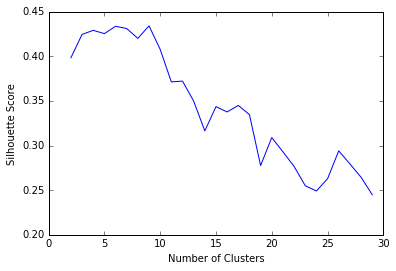

In [1199]:
#determine optimal silhouette score by plotting score as function of k clusters
#determine proper color threshold in dendrogram based on silhouette method
#depends on communities from sklearn's kmeans clustering above
from sklearn.metrics import silhouette_score
xvalues,yvalues=[],[]
for k in range(2,30):
    c,cs,rl=kmean_cluster(k)
    s=silhouette_score(np.array(xarray),labels=rl,metric='euclidean')
    xvalues.append(k)
    yvalues.append(s)
plt.plot(xvalues,yvalues)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
#plt.title("Determination of Clustering Threshold")
#print(zip(xvalues,yvalues)) #optimal around 10 clusters for 5000 threshold

0.8210094423076593 10


Text(0, 0.5, 'Distance')

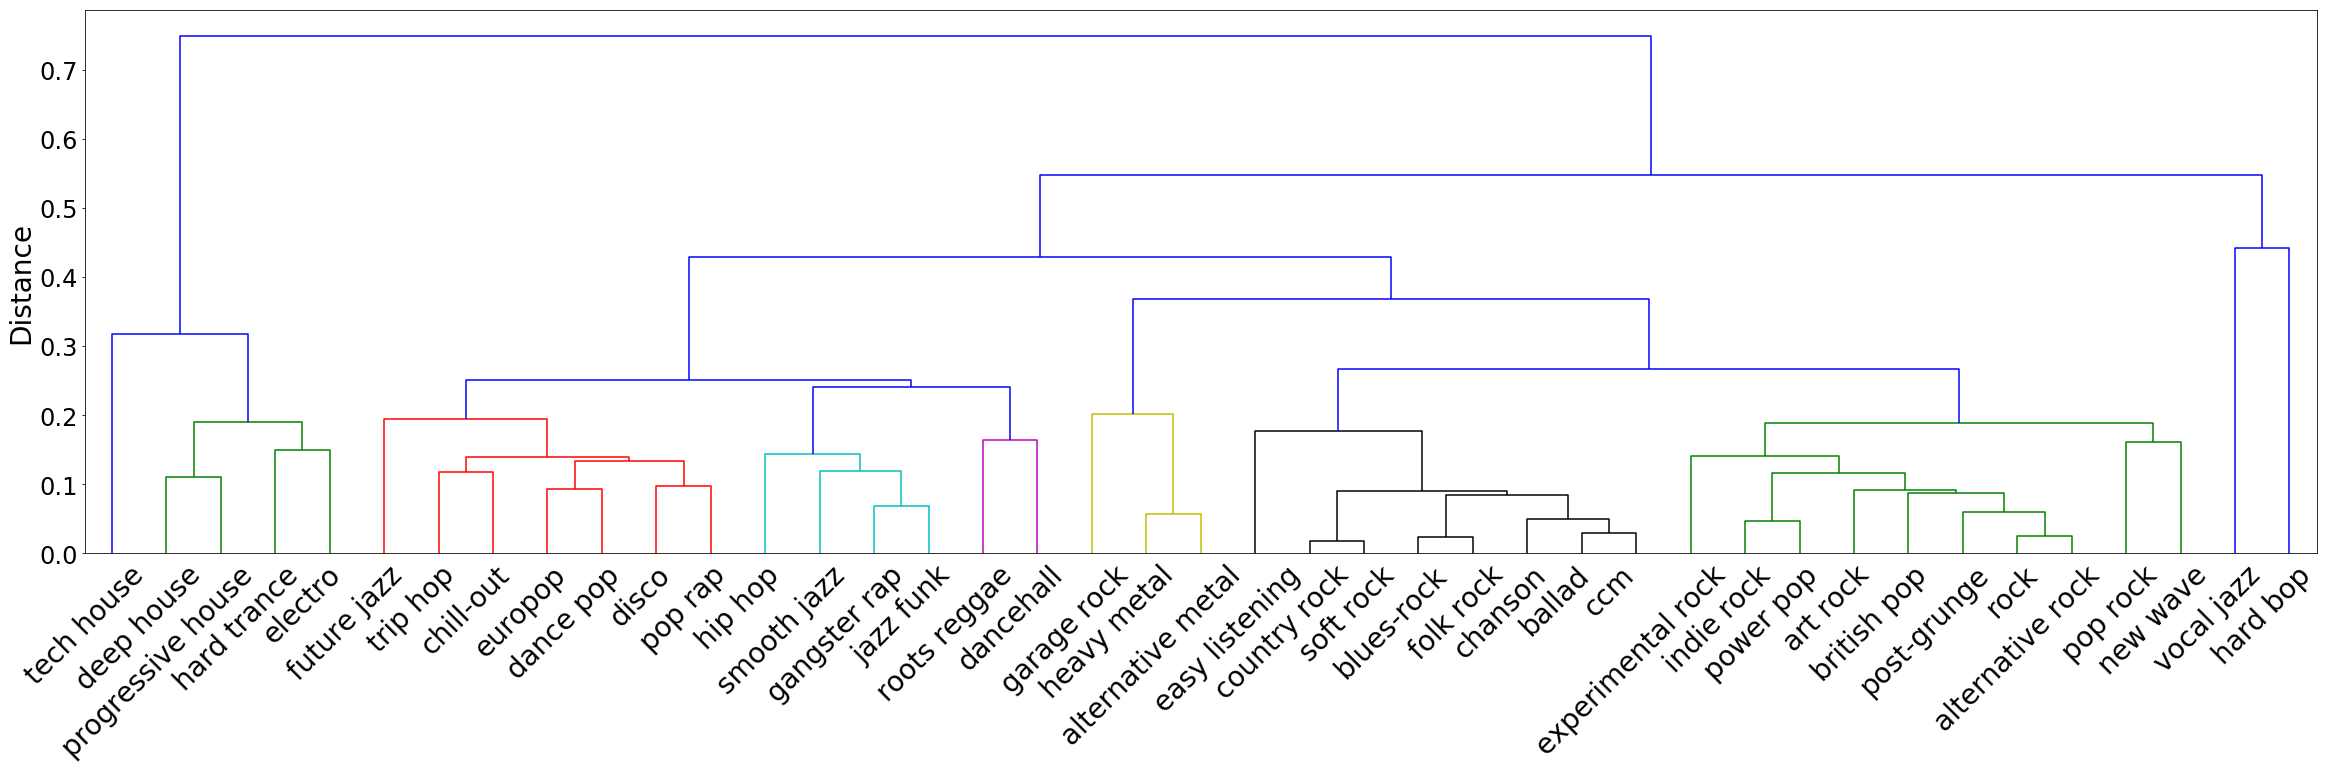

In [43]:
#create a dendrogram based on agglomerative clustering
from scipy.cluster.hierarchy import linkage,dendrogram,cophenet,fcluster
from scipy.spatial.distance import pdist
max_d = 0.22
#colors=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
xarray=np.array([[genre_means[genre]['pconEntropy'],genre_means[genre]['lconEntropy'],genre_means[genre]['tconEntropy'],
                 genre_means[genre]['rconEntropy']] for genre in top_genres])
Y=pdist(xarray,metric='euclidean') #creates condensed matrix Y (top half of adjacency matrix, length=len(G.edges())-213)
Z=linkage(xarray,method='centroid')
fig,ax=plt.subplots(figsize=(40,10)) #figsize=(10,40)
dn=dendrogram(Z, color_threshold=max_d, get_leaves=True, labels=top_genres, leaf_rotation=45, #leaf_rotation=0,45
             orientation='top', leaf_font_size=28) #orientation='right', 'top'
#print(0.3*max(Z[:,2]),dn['ivl'],dn['color_list'],len(top_genres))
c, coph_dists = cophenet(Z, pdist(xarray))
print(c, len(set(fcluster(Z, max_d, criterion='distance'))))#,sorted(zip(fcluster(Z, max_d, criterion='distance'),top_genres))
#if horizontal, change the xticks

xt=[x-5 for x in ax.get_xticks()]
xt[2]=13.5
xt[3]=28
xt[5]=48
xt[9]=88
xt[10]=102 #disco
xt[13]=128
xt[14]=138
xt[16]=158
xt[19]=188
xt[20]=196 #alternative metal
xt[23]=232
xt[25]=252
xt[29]=284 #experimental rock
xt[31]=308
xt[33]=328
xt[34]=338
xt[35]=354
xt[36]=355
xt[37]=372 #pop rock
ax.set_xticks(xt)
#print(ax.get_xticks()) 
plt.ylabel("Distance",fontsize=28)
#plt.savefig('music_complexity/Figures/genre_dendrogram_t5000_horizontal.pdf',dpi=300,bbox_inches = "tight")

In [44]:
#what songs are in the Hot 100?
hot_genres=[song.terms for song in bb]
hot_genres=Counter(hot_genres).items()
hot_genres=sorted(hot_genres,key=lambda x: x[1],reverse=True)
print(hot_genres[:10])

[('soft rock', 510), ('pop rock', 476), ('disco', 354), ('country rock', 314), ('dance pop', 265), ('motown', 203), ('blues-rock', 190), ('ballad', 180), ('hip hop', 171), ('rock', 169)]


In [45]:
#top genre means and variances
top_genres=['pop','heavy metal','jazz','hip hop','electronica']
for etype in ['pconEntropy','lconEntropy','tconEntropy','rconEntropy']:
    for genre in top_genres:
        print(genre,etype,genre_means[genre][etype],genre_variances[genre][etype],len(genres[genre]))

pop pconEntropy 2.3626987278972202 0.11211150245923261 2394
heavy metal pconEntropy 2.13136057738363 0.18498439413610185 9782
jazz pconEntropy 2.414355673463051 0.29570593009036283 3828
hip hop pconEntropy 2.4154517878264437 0.2283957813544892 27903
electronica pconEntropy 2.37347833584234 0.26898423911723285 1594
pop lconEntropy 3.059017568055998 0.0955275955087947 2394
heavy metal lconEntropy 2.679503414060316 0.13712691033045155 9782
jazz lconEntropy 3.2960751656574976 0.18590431255565462 3828
hip hop lconEntropy 3.182011508939843 0.14909917066187967 27903
electronica lconEntropy 2.9519288065525964 0.2407549953440366 1594
pop tconEntropy 0.1922031355092106 0.0353349302112151 2394
heavy metal tconEntropy 0.36167744390057943 0.07590906397572422 9782
jazz tconEntropy 0.2702968060913506 0.07833013795758624 3828
hip hop tconEntropy 0.24745044006556943 0.059327038443870446 27903
electronica tconEntropy 0.47165889125258714 0.16848031699960292 1594
pop rconEntropy 2.7512917227651217 0.23066

In [46]:
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [47]:
#deviation from norm (based on bootstrap sample) for each feature
deviations={'Hot 100':{},'pop':{},'hip hop':{},'jazz':{},'heavy metal':{},'electronica':{}}

bb (2.3144186770235713, 2.3061755398905563, 2.3226618141565862)
bb (3.107940612861657, 3.1008879236340525, 3.1149933020892617)
bb (0.1514933114614396, 0.14822854043829595, 0.15475808248458325)
bb (2.754019017867728, 2.7437406424211863, 2.76429739331427)
Average Random Sample length:  6661
random sample (2.3286521952336523, 2.3276463445288145, 2.32965804593849)
random sample (3.0265115892609167, 3.0254741873983244, 3.027548991123509)
random sample (0.29301713742395874, 0.2923118773448181, 0.29372239750309936)
random sample (2.766484236176034, 2.765306219940444, 2.767662252411624)


Text(0.5, 1.05, 'Hot 100')

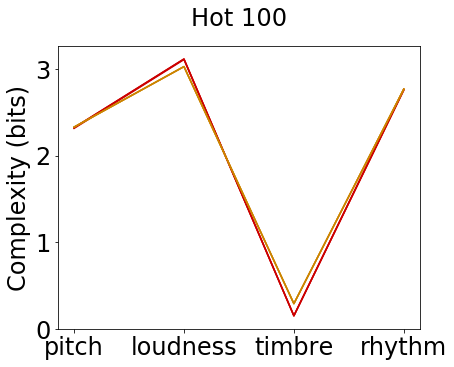

In [148]:
#show complexity means for Hot 100, compare to random sample of the same size
top_genres=['pop','hip hop','jazz','heavy metal','electronica']
genre='Hot 100'
sample_length=len(bb) #length of each sample
samples=100
xvalues=['pitch','loudness','timbre','rhythm']
y1values,y2values=[],[] #means
lowers,uppers=[],[] #for CIs
lowers2,uppers2=[],[] #for CIs
fig, ax = plt.subplots(figsize=(6.5,5.2))
deviations[genre]={'pitch':[],'loudness':[],'timbre':[],'rhythm':[]}

#Hot 100
pmeans=[song.pconEntropy for song in bb if song.pentropy>0]
lmeans=[song.lconEntropy for song in bb if song.lentropy>0]
tmeans=[song.tconEntropy for song in bb if song.tentropy>0]
rmeans=[song.rconEntropy for song in bb if song.rentropy>0]
for arr in [pmeans,lmeans,tmeans,rmeans]:
    y1values.append(np.mean(arr))
    ci_rmean = mean_confidence_interval(arr) #95% CI
    lowers.append(abs(ci_rmean[1]-ci_rmean[0]))
    uppers.append(abs(ci_rmean[2]-ci_rmean[0]))
    print("bb",ci_rmean)

#random sample
pmeans,lmeans,tmeans,rmeans=[],[],[],[]
for i in range(samples):
    rbins=rnd.sample(allsongs,sample_length) #use subsample to be year selective
    pavg=np.mean([song.pconEntropy for song in rbins if song.pentropy>0])
    lavg=np.mean([song.lconEntropy for song in rbins if song.lentropy>0])
    tavg=np.mean([song.tconEntropy for song in rbins if song.tentropy>0])
    ravg=np.mean([song.rconEntropy for song in rbins if song.rentropy>0])
    pmeans.append(pavg)
    lmeans.append(lavg)
    tmeans.append(tavg)
    rmeans.append(ravg)
    #append deviations
    deviations[genre]['pitch'].append(y1values[0]-pavg)
    deviations[genre]['loudness'].append(y1values[1]-lavg)
    deviations[genre]['timbre'].append(y1values[2]-tavg)
    deviations[genre]['rhythm'].append(y1values[3]-ravg)


print("Average Random Sample length: ",sample_length)
for arr in [pmeans,lmeans,tmeans,rmeans]:
    y2values.append(np.mean(arr))
    ci_rmean = mean_confidence_interval(arr) #95% CI
    lowers2.append(abs(ci_rmean[1]-ci_rmean[0]))
    uppers2.append(abs(ci_rmean[2]-ci_rmean[0]))
    print("random sample",ci_rmean)

#plot
plt.plot(xvalues,y1values,label='Hot 100',color='#CC0000')
plt.plot(xvalues,[sum(x) for x in zip(lowers, y1values)],color='#CC0000')
plt.plot(xvalues,[sum(x) for x in zip(uppers, y1values)],color='#CC0000')

plt.plot(xvalues,y2values,label='random sample',color='#CC8400')
plt.plot(xvalues,[sum(x) for x in zip(lowers2, y2values)],color='#CC8400')
plt.plot(xvalues,[sum(x) for x in zip(uppers2, y2values)],color='#CC8400')

plt.ylabel("Complexity (bits)")
plt.title("Hot 100",y=1.05) #specify entropy type
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.2),fancybox=True, shadow=False, ncol=2)
#plt.savefig('music_complexity/Figures/bb_complexity_means.pdf',dpi=300,bbox_inches = "tight") #specify

pop (2.3626987278972202, 2.3492765946706125, 2.376120861123828)
pop (3.059017568055998, 3.0466278654477863, 3.07140727066421)
pop (0.19220313550921062, 0.18466786968274224, 0.199738401335679)
pop (2.7512917227651217, 2.732035049654133, 2.7705483958761103)
Average Random Sample length:  2394
random sample (2.3285978370106353, 2.32661446888788, 2.3305812051333907)
random sample (3.026471512216158, 3.0247640386816212, 3.0281789857506944)
random sample (0.2931462538360433, 0.2917905691934821, 0.2945019384786045)
random sample (2.765933738566346, 2.763705538442146, 2.768161938690546)


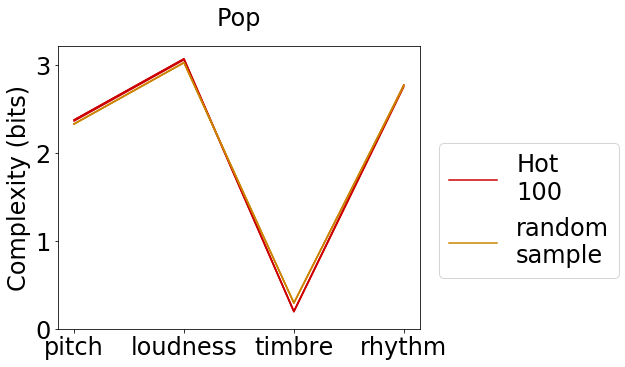

In [156]:
#show complexity means by genre, compare to random sample of the same size
#must run individually for each genre
top_genres=['pop','hip hop','jazz','heavy metal','electronica']
genre=top_genres[0]
sample_length=len(genres[genre]) #length of each sample
samples=100
xvalues=['pitch','loudness','timbre','rhythm']
y1values,y2values=[],[] #means
lowers,uppers=[],[] #for CIs
lowers2,uppers2=[],[] #for CIs
fig, ax = plt.subplots(figsize=(6.5,5.2))
deviations[genre]={'pitch':[],'loudness':[],'timbre':[],'rhythm':[]}

#Hot 100
pmeans=[song.pconEntropy for song in genres[genre] if song.pentropy>0]
lmeans=[song.lconEntropy for song in genres[genre] if song.lentropy>0]
tmeans=[song.tconEntropy for song in genres[genre] if song.tentropy>0]
rmeans=[song.rconEntropy for song in genres[genre] if song.rentropy>0]
for arr in [pmeans,lmeans,tmeans,rmeans]:
    y1values.append(np.mean(arr))
    ci_rmean = mean_confidence_interval(arr) #95% CI
    lowers.append(abs(ci_rmean[1]-ci_rmean[0]))
    uppers.append(abs(ci_rmean[2]-ci_rmean[0]))
    print(genre,ci_rmean)

#random sample
pmeans,lmeans,tmeans,rmeans=[],[],[],[]
for i in range(samples):
    rbins=rnd.sample(allsongs,sample_length) #use subsample to be year selective
    pavg=np.mean([song.pconEntropy for song in rbins if song.pentropy>0])
    lavg=np.mean([song.lconEntropy for song in rbins if song.lentropy>0])
    tavg=np.mean([song.tconEntropy for song in rbins if song.tentropy>0])
    ravg=np.mean([song.rconEntropy for song in rbins if song.rentropy>0])
    pmeans.append(pavg)
    lmeans.append(lavg)
    tmeans.append(tavg)
    rmeans.append(ravg)
    #append deviations
    deviations[genre]['pitch'].append(y1values[0]-pavg)
    deviations[genre]['loudness'].append(y1values[1]-lavg)
    deviations[genre]['timbre'].append(y1values[2]-tavg)
    deviations[genre]['rhythm'].append(y1values[3]-ravg)


print("Average Random Sample length: ",sample_length)
for arr in [pmeans,lmeans,tmeans,rmeans]:
    y2values.append(np.mean(arr))
    ci_rmean = mean_confidence_interval(arr) #95% CI
    lowers2.append(abs(ci_rmean[1]-ci_rmean[0]))
    uppers2.append(abs(ci_rmean[2]-ci_rmean[0]))
    print("random sample",ci_rmean)

#plot
plt.plot(xvalues,y1values,label='Hot\n100',color='#CC0000')
plt.plot(xvalues,[sum(x) for x in zip(lowers, y1values)],color='#CC0000')
plt.plot(xvalues,[sum(x) for x in zip(uppers, y1values)],color='#CC0000')

plt.plot(xvalues,y2values,label='random\nsample',color='#CC8400')
plt.plot(xvalues,[sum(x) for x in zip(lowers2, y2values)],color='#CC8400')
plt.plot(xvalues,[sum(x) for x in zip(uppers2, y2values)],color='#CC8400')

plt.yticks([0,1,2,3])
plt.ylabel("Complexity (bits)")
plt.title(genre.title(),y=1.05) #specify entropy type
plt.legend(loc='upper center', bbox_to_anchor=(1.3, .7),fancybox=True, shadow=False, ncol=1)
#plt.savefig('music_complexity/Figures/'+genre+'_complexity_means.pdf',dpi=300,bbox_inches = "tight") #specify

Text(0.5, 1.02, 'Complexity per genre')

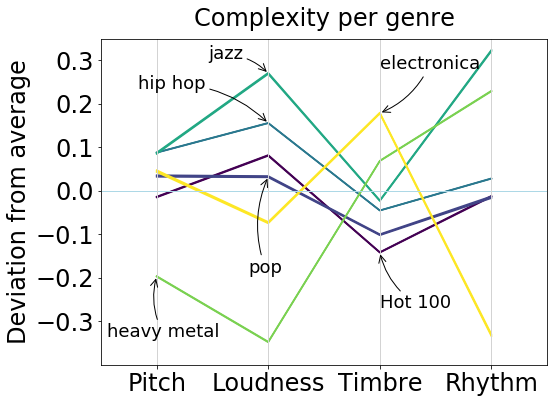

In [157]:
#plot genre deviations
from matplotlib import cm,colors
deviation_CIs={genre:[] for genre in deviations}
for genre in deviations:
    for etype in deviations[genre]:
        deviation_CIs[genre].append(mean_confidence_interval(deviations[genre][etype]))

fig, ax = plt.subplots(figsize=(8,6))
xvalues=['Pitch','Loudness','Timbre','Rhythm']
color=[]
cmap = cm.get_cmap('viridis', 6) #viridis, inferno, magma, plasma

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color.append(colors.rgb2hex(rgb))
    
annotations={'Hot 100':2,'pop':1,'hip hop':1,'jazz':1,'heavy metal':0,'electronica':2} #x-value to annotate
texts={'Hot 100':(0,-60),'pop':(-20,-100),'hip hop':(-130,30),'jazz':(-60,10),'heavy metal':(-50,-65),'electronica':(0,40)} #xytext to annotate
    
for i,genre in enumerate(deviations):
    yvalues=[deviation_CIs[genre][i][0] for i in range(4)]
    lowers=[deviation_CIs[genre][i][1] for i in range(4)]
    uppers=[deviation_CIs[genre][i][2] for i in range(4)]
    #print(y1values,lowers,uppers)
    plt.plot(xvalues,yvalues,label=genre,color=color[i])
    plt.plot(xvalues,lowers,color=color[i])
    plt.plot(xvalues,uppers,color=color[i])
    #annotate label
    ax.annotate(genre, xy=(annotations[genre],yvalues[annotations[genre]]), xycoords='data',
                xytext=texts[genre], textcoords='offset points',ha="left", va="bottom",fontsize=18,
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', color='black'))

ax.axhline(y=0, color='lightblue', linewidth=1)
ax.axvline(x=0.0, color='lightgrey', linewidth=1)
ax.axvline(x=1, color='lightgrey', linewidth=1)
ax.axvline(x=2, color='lightgrey', linewidth=1)
ax.axvline(x=3, color='lightgrey', linewidth=1)
ax.set_ylabel('Deviation from average')
ax.set_ylim([-.4,.35])
ax.set_xlim([-.5,3.5])
ax.set_yticks([-.3,-.2,-.1,0,.1,.2,.3])
#plt.setp(xtickNames, rotation=-45)
plt.title("Complexity per genre",y=1.02)
#plt.legend(loc='upper center', bbox_to_anchor=(1.4, .9),fancybox=True, shadow=False, ncol=1)
#plt.savefig('music_complexity/Figures/genre_deviations_line_annotated.pdf',dpi=300,bbox_inches = "tight") #specify

In [171]:
#get (continuous) samples for statistical tests
top_genres=['pop','heavy metal','jazz','hip hop','electronica']
samples=1000
gsample,bbsample,allsample,rsample={genre:[] for genre in top_genres},[],[],[]
rmeans,rstds=[],[]
#genre
for genre in top_genres:
    for song in genres[genre]:
        try:
            gsample[genre].append(float(song.pconEntropy)) #specify entropy type
        except: pass
    print(genre,len(gsample[genre])),
for song in bb:
    try:
        bbsample.append(float(song.pconEntropy)) #specify entropy type
    except: pass
print('Hot 100',len(bbsample)),
for song in allsongs:
    try:
        allsample.append(float(song.pconEntropy)) #specify entropy type
    except: pass
#print('all',len(allsample)),
for i in range(samples):
    rsample=rnd.sample(allsongs,len(bbsample)) #create a random sample the same size as the Hot 100
    rsample=[song.pconEntropy for song in rsample if song.pconEntropy] #specify entropy type
    rmeans.append(np.mean(rsample))
    rstds.append(np.std(rsample))
print('random sample',len(rsample))
#estimate rsample as normal distribution
mu,std=np.mean(rmeans),np.mean(rstds)
#sample this distribution, i.e. make sure we have a 'representative' random sample
rsample = np.random.normal(mu, std, len(bbsample))
print(mu,std)
print(mean_confidence_interval(rsample))

pop 2394
heavy metal 9782
jazz 3828
hip hop 27903
electronica 1594
Hot 100 6661
random sample 6658
2.3284698816452747 0.4646865348574952
(2.323444059284063, 2.31205197425234, 2.3348361443157857)


In [172]:
#compare sample means using Welch's t-test
#significance tests between Hot 100 and random sample
print("T-test between all and random",ttest_ind(allsample,rsample,equal_var=False))
print("T-test between all and Hot 100",ttest_ind(allsample,bbsample,equal_var=False))
print("T-test between Hot 100 and random",ttest_ind(bbsample,rsample,equal_var=False))
#compare to genre
print("T-test between Hot 100 and pop",ttest_ind(gsample['pop'],bbsample,equal_var=False))
for genre in gsample:
    print("T-test between random and %s" % genre,ttest_ind(gsample[genre],rsample,equal_var=False))

T-test between all and random Ttest_indResult(statistic=0.7246945389975008, pvalue=0.4686645456588756)
T-test between all and Hot 100 Ttest_indResult(statistic=3.130229868003553, pvalue=0.0017540482117766629)
T-test between Hot 100 and random Ttest_indResult(statistic=-1.2582227769200507, pvalue=0.20833541095499447)
T-test between Hot 100 and pop Ttest_indResult(statistic=6.01009005353071, pvalue=2.0070665674646083e-09)
T-test between random and pop Ttest_indResult(statistic=4.371858211324154, pvalue=1.2528440070975028e-05)
T-test between random and heavy metal Ttest_indResult(statistic=-26.463633776313962, pvalue=1.8588645143019763e-150)
T-test between random and jazz Ttest_indResult(statistic=8.627394345382552, pvalue=7.653197957181448e-18)
T-test between random and hip hop Ttest_indResult(statistic=14.204323073382824, pvalue=2.342671949054273e-45)
T-test between random and electronica Ttest_indResult(statistic=3.5149611434563846, pvalue=0.0004484252270490304)


In [173]:
#determine empirical distribution function to estimate CDF
#compare continuous distributions using two-sample KS test
from scipy.stats import ks_2samp

print("Length of samples: ",len(allsample),len(bbsample),len(gsample),len(rsample)," Genre is",genre)
print("KS test between all and Hot 100", ks_2samp(allsample,bbsample))
print("KS test between all and pop", ks_2samp(allsample,gsample['pop']))
print("KS test between Hot 100 and pop", ks_2samp(bbsample,gsample['pop']))
print("KS test between all and random", ks_2samp(allsample,rsample))
print("KS test between Hot 100 and random", ks_2samp(bbsample,rsample))
for genre in gsample:
    print("KS test between %s and random" % genre, ks_2samp(gsample[genre],rsample))

Length of samples:  905896 6661 5 6661  Genre is electronica
KS test between all and Hot 100 Ks_2sampResult(statistic=0.082129736746823, pvalue=2.7805075135406117e-39)
KS test between all and pop Ks_2sampResult(statistic=0.08681778376429047, pvalue=3.898439953576122e-16)
KS test between Hot 100 and pop Ks_2sampResult(statistic=0.07901114443517587, pvalue=4.965489486143313e-10)
KS test between all and random Ks_2sampResult(statistic=0.058054125418370295, pvalue=7.694897932325276e-20)
KS test between Hot 100 and random Ks_2sampResult(statistic=0.09187809638192468, pvalue=5.992889668229388e-25)
KS test between pop and random Ks_2sampResult(statistic=0.1377656597079949, pvalue=1.2574609480744581e-29)
KS test between heavy metal and random Ks_2sampResult(statistic=0.17500623331917597, pvalue=2.996892372408507e-106)
KS test between jazz and random Ks_2sampResult(statistic=0.11889965404763325, pvalue=2.0056832181108685e-30)
KS test between hip hop and random Ks_2sampResult(statistic=0.1731274

Average Random Sample:  2.32723782460211 0.21802456743652412
Hot 100:  2.3144186770235713 0.11776201513663552
pop : 2.3626987278972202 0.11211150245923261
heavy metal : 2.13136057738363 0.18498439413610185
jazz : 2.414355673463051 0.29570593009036283
hip hop : 2.4154517878264437 0.2283957813544892
electronica : 2.37347833584234 0.26898423911723274


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

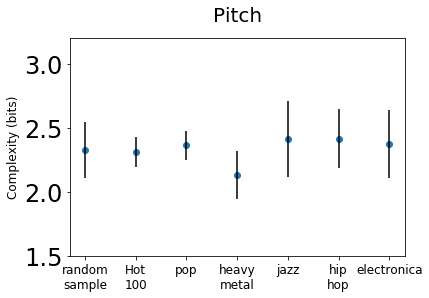

In [175]:
#show mean and variances of select genres
from matplotlib.ticker import FormatStrFormatter
#etype='pconEntropy'
top_genres=['pop','heavy metal','jazz','hip hop','electronica']
xvalues=['random\nsample','Hot\n100','pop','heavy\nmetal','jazz','hip\nhop','electronica']
yvalues,ystds=[],[]
fig, ax = plt.subplots()

#bootstrap random sample
all_rbins=[0]*len(bb)
samples=1000
rmeans,rstds=[],[]
rdic={}
for i in range(samples):
    rbins=rnd.sample(subsample,len(bb)) #create a random sample the same size as gbins, use subsample to be year selective
    rbins=[song.pconEntropy for song in rbins if song.pentropy>0] #specify entropy type
    rmeans.append(np.mean(rbins))
    rstds.append(np.std(rbins)) #std
    all_rbins=Counter(rbins).items()
    for k in all_rbins:
        rdic.setdefault(k[0],0)
        rdic[k[0]]+=k[1]
rdic={k:rdic[k]/samples for k in rdic}

print("Average Random Sample: ",np.mean(rmeans),np.mean(rstds)**2)
yvalues.append(np.mean(rmeans))
ystds.append(np.mean(rstds)**2) #variance
#ci_rmean, ci_rstd = mean_confidence_interval(rmeans),mean_confidence_interval(rstds) #95% CI
#print(ci_rmean, ci_rstd)
#print("Random sample length: ",len(rbins))

#Hot 100
arr=[song.pconEntropy for song in bb if song.pentropy>0] #specify entropy type
print("Hot 100: ",np.mean(arr),np.std(arr)**2)
yvalues.append(np.mean(arr))
ystds.append(np.std(arr)**2)

#top genres
for genre in top_genres:
    #print(genre_means[genre][etype],genre_variances[genre][etype])
    arr=[song.pconEntropy for song in genres[genre] if song.pentropy>0] #specify entropy type
    print(genre,":",np.mean(arr),np.std(arr)**2)
    yvalues.append(np.mean(arr))
    ystds.append(np.std(arr)**2)
    
    
plt.scatter(xvalues,yvalues)
plt.errorbar(xvalues,yvalues,yerr=[ystds,ystds],color='black',ls='none')
plt.ylim([1.5,3.2]) #pitch
#plt.ylim([2.1,3.9]) #loudness
#plt.ylim([-.1,1]) #timbre
#plt.ylim([1.7,3.7]) #rhythm
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.ylabel("Complexity (bits)",fontsize=12)
plt.title("Pitch",y=1.05,fontsize=20) #specify entropy type
#plt.legend(loc=1,fontsize=10)
plt.xticks(fontsize=12)
#plt.savefig('music_complexity/Figures/pitch_complexity_means_bygenre.pdf') #specify complexity type

### Popular Song Similarity

In [ ]:
#read in bb songs from text file, takes ~43% memory for all raw (or ~37%)
total=0
genres={}
b=0
with open('bb_songs_all_raw_filtered.txt') as f: #'allsongs_filtered.txt', 'msdA.txt', 'millionsongsubset_all_raw.txt'
    for i in range(6716): #39100 msdA, 468 in A, 3204 in A-I, 2052 in J-R, 1459 in S-Z (mauch Hot 100)
        arr=[]
        for k in range(26): #16 for thin version, 26 for full version
            arr.append(f.readline().strip())

        try: song=FullSongData(arr)
        except: 
            #print(arr[:4])
            b+=1
            break
        try:
            genres.setdefault(song.terms[0],set([])).add(song)
        except IndexError: 
            genres.setdefault('unknown',set([])).add(song)
        total+=1
        del arr
#print(total,str(b)+' bad songs')

In [19]:
bb_songs={song for genre in genres for song in genres[genre]}
print(len(bb_songs))

6661


In [18]:
#are hit songs becoming less diverse relative to other popular songs?
#calculate the KL divergence between two distributions
import scipy.stats as ss
def KL(pk,qk):
    return ss.entropy(pk,qk,base=2)

In [20]:
#calculate difference from other Hot 100 songs per year
bb_years={}
for song in bb_songs:
    bb_years.setdefault(song.year,[])
    bb_years[song.year].append(song)
print(sorted(bb_years.keys()))

[0, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]


In [26]:
#look at all codewords in the Hot 100
from collections import Counter
all_codes={'pcodes':Counter(),'lcodes':Counter(),'tcodes':Counter(),'rcodes':Counter()}
for song in bb_songs:
    all_codes['pcodes']+=Counter(song.pcodes)
    all_codes['lcodes']+=Counter(song.lcodes)
    all_codes['tcodes']+=Counter(song.tcodes)
    try:
        all_codes['rcodes']+=Counter(song.rcodes)
    except: pass

In [158]:
#view codewords and entropy of all Hot 100 codewords
#note that each feature has very different number of codewords/entropy
#so it makes sense to compare divergences within features, not across features
for code in all_codes:
    print(code,len(all_codes[code]))
    pk=[all_codes[code][k] for k in all_codes[code]]
    print("entropy",scipy.stats.entropy(pk,base=2))

pcodes 4089
entropy 8.63778166334
tcodes 175792
entropy 16.9904757199
lcodes 65
entropy 4.61786625216
rcodes 310
entropy 3.82858925527


In [22]:
#view differences over years compared to other songs in that year
from collections import Counter
year_codes={year:{'pcodes':Counter(),'lcodes':Counter(),'tcodes':Counter(),'rcodes':Counter()} for year in bb_years}
for year in bb_years:
    for song in bb_years[year]:
        year_codes[year]['pcodes']+=Counter(song.pcodes)
        year_codes[year]['lcodes']+=Counter(song.lcodes)
        year_codes[year]['tcodes']+=Counter(song.tcodes)
        try:
            year_codes[year]['rcodes']+=Counter(song.rcodes)
        except:
            pass

In [34]:
dKL_yearly={year:{'pcodes':[],'lcodes':[],'tcodes':[],'rcodes':[]} for year in bb_years}

In [29]:
#NOTE: KL defined even if pk(x)=0 so compare based on qk(x)
#this assumes that we ignore any symbols in pk that are not in qk!
etype='tcodes'
for year in bb_years:
    if year<=1959: continue
    for song in bb_years[year]:
        try:
            array=Counter(song.tcodes) #SPECIFY entropy type
        except:
            continue
        other_codes=year_codes[year][etype]-array #subtract out this song's influence on the year
        qk=[other_codes[k] for k in other_codes]
        pk=[]
        for k in other_codes:
            if k in array:
                pk.append(array[k])
            else:
                pk.append(0)
        dKL_yearly[year][etype].append(KL(pk,qk)) #compare song to yearly distribution

(2.160569259856736, 2.140356726452436, 2.1807817932610356)
Year significantly higher than overall mean [1963, 1964, 1965, 1985, 1990, 1992, 2007]
Year significantly lower than overall mean [1972, 1974, 1975, 1976, 1977, 1978, 1980, 1998, 2003]
pcodes
Regression:  0.034	
Regression:  -0.005	
Regression:  -0.004	
Regression:  0.001	
linear regression slope:  [-3.05674453e-04  2.76718021e+00]
(0.6716842491089491, 0.6380070528935645, 0.7053614453243336)
Year significantly higher than overall mean [1961, 1962, 1963, 1964, 1965, 1966, 1986]
Year significantly lower than overall mean [1976, 1980, 1994, 1996, 2000, 2001, 2002, 2003, 2007, 2008, 2009]
lcodes
Regression:  -0.024	
Regression:  -0.013	
Regression:  -0.002	
Regression:  -0.005	
linear regression slope:  [-6.00613855e-03  1.25908662e+01]
(7.395176187518867, 7.345662985978723, 7.444689389059012)
Year significantly higher than overall mean [1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1990, 1992, 1994, 1995, 2004, 2005, 2010]
Year 

Text(0.5, 0.95, 'Yearly KL divergence across features')

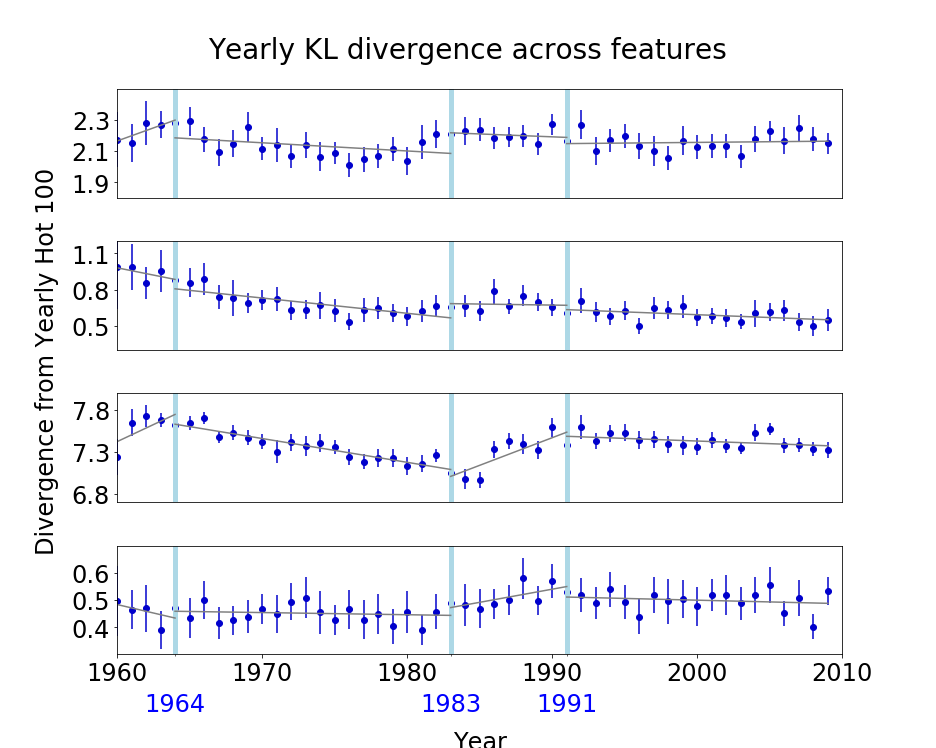

In [277]:
#plot KL divergences with regression lines and change points
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
lowess = sm.nonparametric.lowess
regression=True
etypes=['pcodes','lcodes','tcodes','rcodes'] #with CIs
types={'pcodes':'Pitch','lcodes':'Loudness','tcodes':'Timbre','rcodes':'Rhythm'}
min_year=1959
max_year=2011
dKL_yearly_CIs={etype:() for etype in etypes}
#plot info
fig, ax = plt.subplots(len(etypes),1,figsize=(13,2.6*len(etypes)),tight_layout=False) #figsize=(7,5) 

for r,etype in enumerate(etypes):
    xvalues=[i+1960 for i in range(50)]
    yvalues=[np.mean(dKL_yearly[year][etype]) for year in xvalues] #with CIs
    lines=ax[r].scatter(xvalues,yvalues,label='Yearly Divergence',color='#0000CC') #linewidths=1
    ax[r].set_xlim([1960,2010])
    if etype=='pitch' or etype=='pcodes':
        ax[r].set_ylim([1.8,2.5])
        ax[r].set_yticks([1.9,2.1,2.3])
    elif etype=='loudness' or etype=='lcodes':
        ax[r].set_ylim([0.3,1.2])
        ax[r].set_yticks([0.5,0.8,1.1])
    elif etype=='timbre' or etype=='tcodes':
        ax[r].set_ylim([6.7,8.0])
        ax[r].set_yticks([6.8,7.3,7.8])
    else:
        ax[r].set_ylim([0.3,0.7])  
        ax[r].set_yticks([0.4,0.5,0.6])

    ci_bb=mean_confidence_interval(yvalues)
    print(ci_bb)
    
    bb_lowers=[abs(mean_confidence_interval(dKL_yearly[year][etype])[1] -
              mean_confidence_interval(dKL_yearly[year][etype])[0]) for year in xvalues]
    bb_uppers=[abs(mean_confidence_interval(dKL_yearly[year][etype])[2] -
               mean_confidence_interval(dKL_yearly[year][etype])[0]) for year in xvalues]
    ax[r].errorbar(xvalues,yvalues,yerr=[bb_lowers,bb_uppers],color='#0000CC',ls='none')

    '''
    #find deviations outside of CIs
    high_yrs=[year for year in sorted(xvalues) if mean_confidence_interval(dKL_yearly[year][etype])[1] >
              mean_confidence_interval(dKL_yearly[year][etype])[2]]
    #print("Hot 100 significantly higher than overall distribution",high_yrs)
    low_yrs=[year for year in sorted(xvalues) if mean_confidence_interval(dKL_yearly[year][etype])[2] <
             mean_confidence_interval(dKL_yearly[year][etype])[1]]
    #print("Hot 100 significantly lower than overall distribution",low_yrs)
    '''
    #alternatively, use one-sample t-test
    diff_yrs=[year for year in bb_years if year>min_year and 
          ttest_1samp(dKL_yearly[year][etype],ci_bb[0])[1] < 0.05]
    high_yrs=[year for year in diff_yrs if np.mean(dKL_yearly[year][etype]) > ci_bb[0]]
    print("Year significantly higher than overall mean",sorted(high_years))
    low_years=[year for year in diff_yrs if np.mean(dKL_yearly[year][etype]) < ci_bb[0]]
    print("Year significantly lower than overall mean",sorted(low_years))
    '''
    #annotate statistical significance on graph
    for year in high_yrs:
        ax[r].annotate("*", xy=(year, mean_confidence_interval(dKL_yearly[year][etype])[2]),
                xytext=(3,-5), textcoords='offset points', ha='center', va='bottom',)
    for year in low_years:
        ax[r].annotate("*", xy=(year, mean_confidence_interval(dKL_yearly[year][etype])[1]),
                xytext=(3,-9), textcoords='offset points', ha='center', va='bottom',) '''
    
    #changepoints
    print(etype)
    bkps=[1964,1983,1991,2011]
    last_pt=min_year+1
    for pt in bkps:
        ax[r].axvline(x=pt, color='lightblue', linewidth=5)
        sub_years=xvalues[last_pt-min_year-1:pt-min_year]
        sub_scores=yvalues[last_pt-min_year-1:pt-min_year]
        last_pt=pt
        if regression:
            fit=np.polyfit(sub_years, sub_scores, 1)
            fit_fn=np.poly1d(fit)
            ax[r].plot(sub_years, fit_fn(sub_years), '-',color='grey') #m*xvalues + b
            print("Regression:  %.3f\t" % fit[0])
            lw=lowess(sub_scores,sub_years,is_sorted=False,return_sorted=True)
            #ax[r].plot([x[0] for x in lw],[x[1] for x in lw],color='grey')
            
    #liner regression over whole range
    if regression:
        fit=np.polyfit(xvalues, yvalues, 1)
        fit_fn=np.poly1d(fit)
        print("linear regression slope: ",fit)
        #plt.plot(xvalues, fit_fn(xvalues), '-',color='grey',label='All Songs') #m*xvalues + b
        #lowess
        lw=lowess(yvalues,xvalues,is_sorted=False,return_sorted=True)
        #plt.plot([x[0] for x in lw],[x[1] for x in lw],color='grey',label='All Songs best fit')
        #annotate regression slope
        #ax[r].annotate("m=%.2f" % fit[0], xy=(2005,fit_fn(2005)), xytext=(5,-40), 
        #               textcoords='offset points', ha='center', va='bottom',)
        
    ax[r].set_title(types[etype],x=-0.25,y=0.4)
    ax[r].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if r==len(etypes)-1:
        ax[r].set_xticks(bkps[:-1],minor=True)
        ax[r].set_xticklabels([1964,1983,1991],y=-.3,color='blue',minor=True)
        ax[r].set_xlabel('Year')
        ax[r].xaxis.set_label_coords(.5, -0.7)
        ax[r].set_ylabel('Divergence from Yearly Hot 100')
        ax[r].yaxis.set_label_coords(-0.08, 2.7)
    else:
        ax[r].set_xticks([])

fig.subplots_adjust(hspace=0.4)
fig.suptitle("Yearly KL divergence across features", y=0.95)
#plt.savefig('music_complexity/Figures/KL_yearly_divergences_with_epochs_labeled_small.pdf',dpi=300,bbox_inches = "tight")

### (Timbre) Codeword Distribution

In [ ]:
#check distribution of timbre codewords to see how complexity may relate to changing production techniques
#should check both Hot 100 and subset; subset takes ~50% memory
total=0
genres={}
b=0
with open('music_complexity/millionsongsubset_all_raw.txt') as f: #'bb_songs_all_raw_filtered.txt'
    for i in range(10001): #39100 msdA, 468 in A, 3204 in A-I, 2052 in J-R, 1459 in S-Z (mauch Hot 100)
        arr=[]
        for k in range(26): #16 for thin version, 26 for full version
            arr.append(f.readline().strip())

        #song=FullSongData(arr)
        try: song=FullSongData(arr)
        except: 
            print arr[:4]
            b+=1
            break
        try:
            genres.setdefault(song.terms[0],set([])).add(song)
        except IndexError: 
            genres.setdefault('unknown',set([])).add(song)
        total+=1
        del arr
print(total,str(b)+' bad songs')

In [22]:
#million song subset (from filtered dataset)
new_genres=genres
new_songs=set([])
for genre in genres:
    for song in genres[genre]: 
        new_songs.add(song)
print(len(new_songs))

9793


In [1171]:
from collections import Counter
timbre_codewords_bb=[]
timbre_by_year_bb={year:[] for year in years_bb} #distinct codewords per year
average_by_year_bb={year:[] for year in years_bb} #average distinct codewords per song per year
songs_by_year_bb={year:0 for year in years_bb}
for song in bb_songs:
    distinct_codewords=set([])
    try:
        for codeword in song.tcodes: #change to other types of codewords
            timbre_codewords_bb.append(codeword)
            distinct_codewords.add(codeword)
            if song.year:
                timbre_by_year_bb[song.year].append(codeword)
        songs_by_year_bb[song.year]+=1
        average_by_year_bb[song.year].append(len(distinct_codewords))
    except:
        pass

In [1172]:
#repeat for million song subset
from collections import Counter
timbre_codewords=[]
timbre_by_year={year:[] for year in years} #distinct codewords per year
average_by_year={year:[] for year in years} #average distinct codewords per song per year
songs_by_year={year:0 for year in years}
for song in new_songs:
    distinct_codewords=set([])
    try:
        for codeword in song.tcodes: #change to other types of codewords
            timbre_codewords.append(codeword)
            distinct_codewords.add(codeword)
            if song.year:
                timbre_by_year[song.year].append(codeword)
        songs_by_year[song.year]+=1
        average_by_year[song.year].append(len(distinct_codewords))
    except:
        pass

4089
3.61066016309 0.47712125472


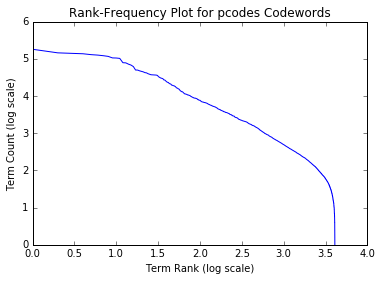

In [1110]:
#graph overall rank-frequency
etype='pcodes'
bins=Counter(timbre_codewords_bb).items()
print(len(bins)) #unique codewords
bins=sorted(bins,key=lambda x: x[1],reverse=True)
#plot rank-frequency
plt.plot([math.log(i+1,10) for i in range(len(bins))],[math.log(c,10) for (t,c) in bins]) #logs in base 10
#plt.plot([i+1 for i in range(len(bins))],[bins[i][1] for i in range(len(bins))])
plt.xlabel('Term Rank (log scale)')
plt.ylabel('Term Count (log scale)')
plt.title('Rank-Frequency Plot for %s Codewords' % etype)

(736.75498971259015, 705.00641772186714, 768.50356170331315) (718.71870186643116, 691.99475477034673, 745.44264896251559)
Billboard statistically higher years [1984]
Billboard statistically lower years []
Hot 100 significantly higher than overall distribution [1979, 1983, 1984, 1993, 2000, 2003]
Hot 100 significantly lower than overall distribution []


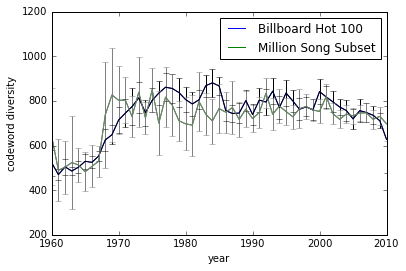

In [1190]:
#plot bb and subset codewords over time
#note consistency of timbre codewords since 1970
min_year=1959
xvalues1=[year for year in years_bb if year>min_year]
yvalues1=[np.mean(average_by_year_bb[year]) for year in years_bb if year>min_year]
xvalues2=[year for year in years if year>min_year and songs_by_year[year]]
yvalues2=[np.mean(average_by_year[year]) for year in years if year>min_year and songs_by_year[year]]

plt.plot(xvalues1,yvalues1,label='Billboard Hot 100')
plt.plot(xvalues2,yvalues2,label='Million Song Subset')
#plt.xlim([1960,2009])
#plt.ylim([50,450]) #pitch
#plt.ylim([10,55]) #loudness
plt.ylim([200,1200]) #timbre
#plt.ylim([10,50]) #rhythm
#plt.title("Average Number of Distinct %s Codewords Per Song Over Time" % etype)
plt.xlabel("year")
plt.ylabel("codeword diversity")
plt.legend()
#show statistical significance
ci_bb = mean_confidence_interval(yvalues1)
ci_all = mean_confidence_interval(yvalues2)
print(ci_bb, ci_all)

#find error ranges
#print(mean_confidence_interval(average_by_year[year]))
bb_lowers=[abs(mean_confidence_interval(average_by_year_bb[year])[1] -
          mean_confidence_interval(average_by_year_bb[year])[0]) for year in xvalues1]
bb_uppers=[abs(mean_confidence_interval(average_by_year_bb[year])[2] -
           mean_confidence_interval(average_by_year_bb[year])[0]) for year in xvalues1]
plt.errorbar(xvalues1,yvalues1,yerr=[bb_lowers,bb_uppers],color='black')
all_lowers=[abs(mean_confidence_interval(average_by_year[year])[1] -
          mean_confidence_interval(average_by_year[year])[0]) for year in xvalues2]
all_uppers=[abs(mean_confidence_interval(average_by_year[year])[2] -
           mean_confidence_interval(average_by_year[year])[0]) for year in xvalues2]
plt.errorbar(xvalues2,yvalues2,yerr=[all_lowers,all_uppers],color='grey')
#find years statistically outside the average based on CI's
high_years,low_years=[],[]
for year in xvalues1:
    if year!=0:
        if mean_confidence_interval(average_by_year[year])[2]<mean_confidence_interval(average_by_year_bb[year])[1]:
            high_years.append(year)
        elif mean_confidence_interval(average_by_year[year])[1]>mean_confidence_interval(average_by_year_bb[year])[2]:
            low_years.append(year)
print("Billboard statistically higher years",high_years)
print("Billboard statistically lower years",low_years)

#alternatively, use Welch's unequal variances t-test, do NOT assume equal variances as we suspect Hot 100 is less varied
diff_yrs=[year for year in years_bb if year>min_year and 
          ttest_ind(average_by_year[year],average_by_year_bb[year],equal_var=False)[1] < 0.05]
high_yrs=[year for year in diff_yrs if np.mean(average_by_year_bb[year]) > np.mean(average_by_year[year])]
print("Hot 100 significantly higher than overall distribution",high_yrs)
low_yrs=[year for year in diff_yrs if np.mean(average_by_year_bb[year]) < np.mean(average_by_year[year])]
print("Hot 100 significantly lower than overall distribution",low_yrs)

In [ ]:
#check electronic genres in terms of timbre, compare to top rock genres
top_genres=[genre for genre in new_genres if len(new_genres[genre])>=30]
for genre in sorted(top_genres,key=lambda genre: np.mean([song.tconEntropy for song in new_genres[genre]]),reverse=True)[:]:
    print(genre,np.mean([song.tconEntropy for song in new_genres[genre]]))

In [1077]:
#find number of distinct codewords and entropy by genre
timbre_by_genre={genre:[] for genre in new_genres} #only use top genres as statistically significant
tconEntropy_by_genre={genre:[] for genre in new_genres}
for genre in new_genres:
    for song in new_genres[genre]:
        distinct_codewords=set([])
        for codeword in song.tcodes:
            distinct_codewords.add(codeword)
        timbre_by_genre[genre].append(len(distinct_codewords))
        tconEntropy_by_genre[genre].append(song.tconEntropy)

Correlation between codewords and timbre complexity:  (0.1246986635205498, 0.22607985793954335)


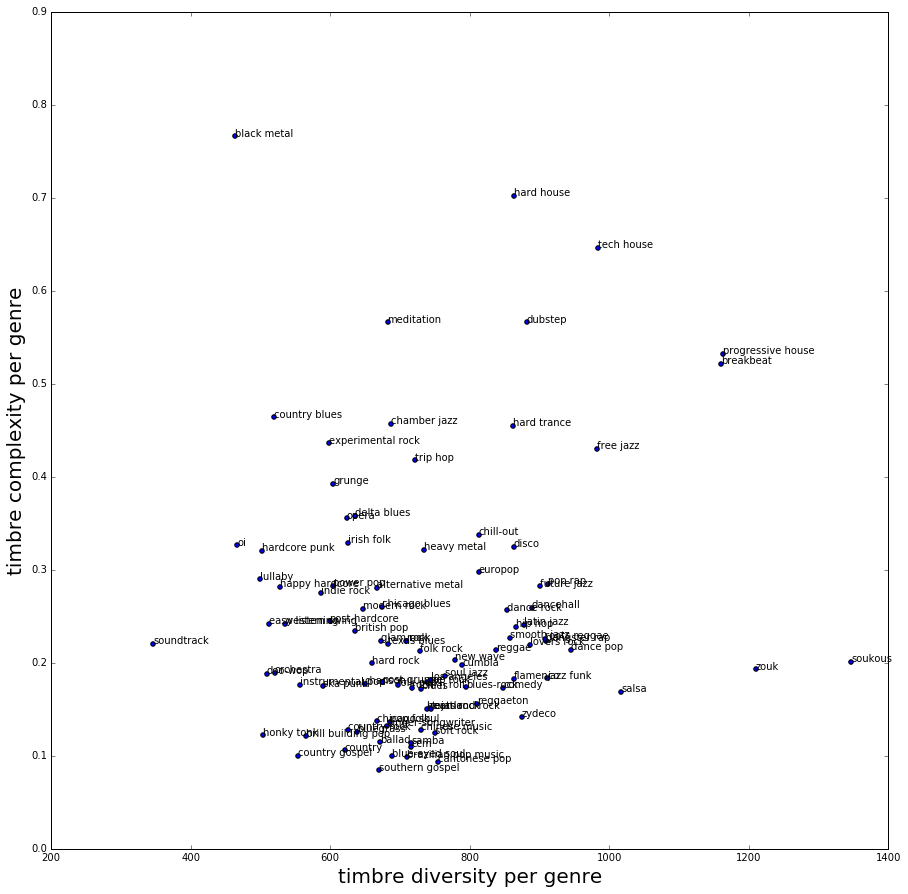

In [1204]:
#view timbre diversity and complexity across genres and check for correlation
from scipy.stats.stats import pearsonr
fig,ax=plt.subplots(figsize=(15,15)) #figsize=(15,15)
xvalues=[np.mean(timbre_by_genre[genre]) for genre in top_genres] #average number of distinct codewords
yvalues=[np.mean(tconEntropy_by_genre[genre]) for genre in top_genres] #average timbre complexity
ax.scatter(xvalues,yvalues)
plt.xlabel("timbre diversity per genre", fontsize=20)
plt.ylabel("timbre complexity per genre", fontsize=20)
#plt.title("Timbre Complexity by Number of Distinct Codewords by Genre", y=1.05, fontsize=24)
for i,label in enumerate(top_genres):
    ax.annotate(label,(xvalues[i],yvalues[i]))
        
print("Correlation between codewords and timbre complexity: ", pearsonr(xvalues,yvalues))

Correlation between codewords and timbre complexity:  (0.036257477796069845, 0.00033227115801367986)


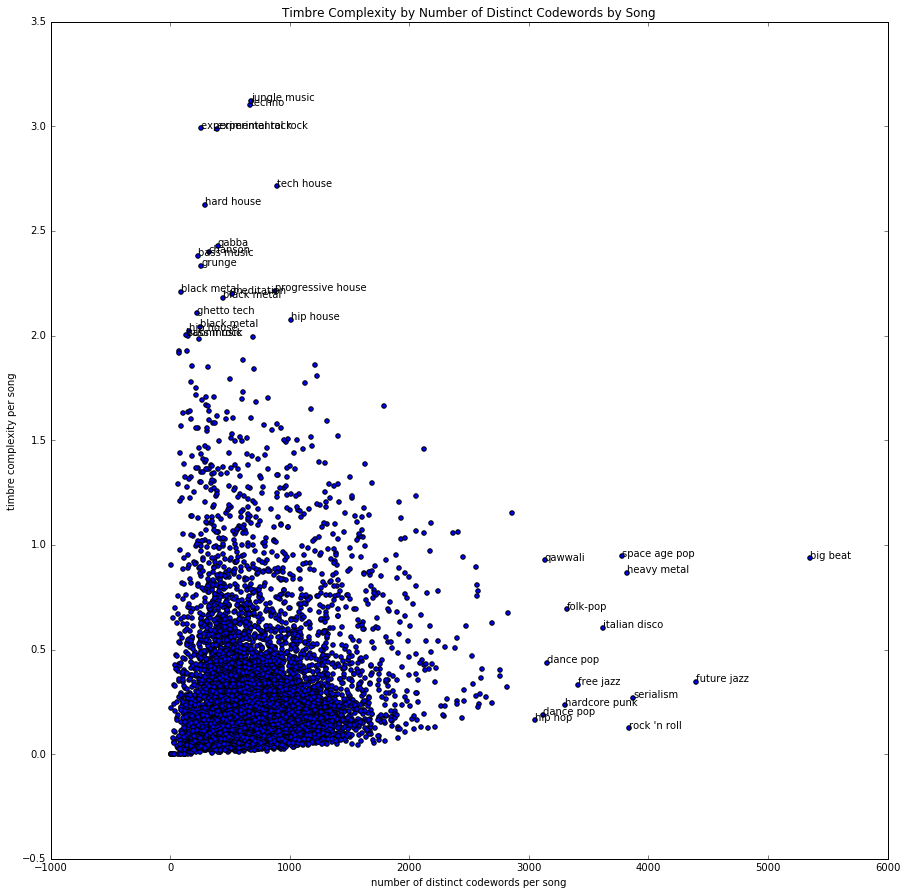

In [95]:
#view timbre diversity and complexity across songs and check for correlation
from scipy.stats.stats import pearsonr
fig,ax=plt.subplots(figsize=(15,15)) #figsize=(15,15)
xvalues=[len(set(song.tcodes)) for song in new_songs] #number of distinct codewords
yvalues=[song.tconEntropy for song in new_songs] #timbre complexity
ax.scatter(xvalues,yvalues)
#plt.xlim([-5,150])
plt.xlabel("number of distinct codewords per song")
plt.ylabel("timbre complexity per song")
plt.title("Timbre Complexity by Number of Distinct Codewords by Song")
for i,song in enumerate(new_songs):
    if yvalues[i]>2 or xvalues[i]>3000: #only label outliers with their respective genre
        ax.annotate(song.terms[0],(xvalues[i],yvalues[i]))
        
print("Correlation between codewords and timbre complexity: ", pearsonr(xvalues,yvalues))

Correlation between codewords and timbre complexity for electronic genres:  (0.13021940690823275, 0.032120676760438012)
Correlation between codewords and timbre complexity for rock genres:  (-0.16299151380856544, 0.0068559947374481952)
Correlation between codewords and timbre complexity for traditional genres:  (-0.18819308096554388, 0.0049025791536293044)


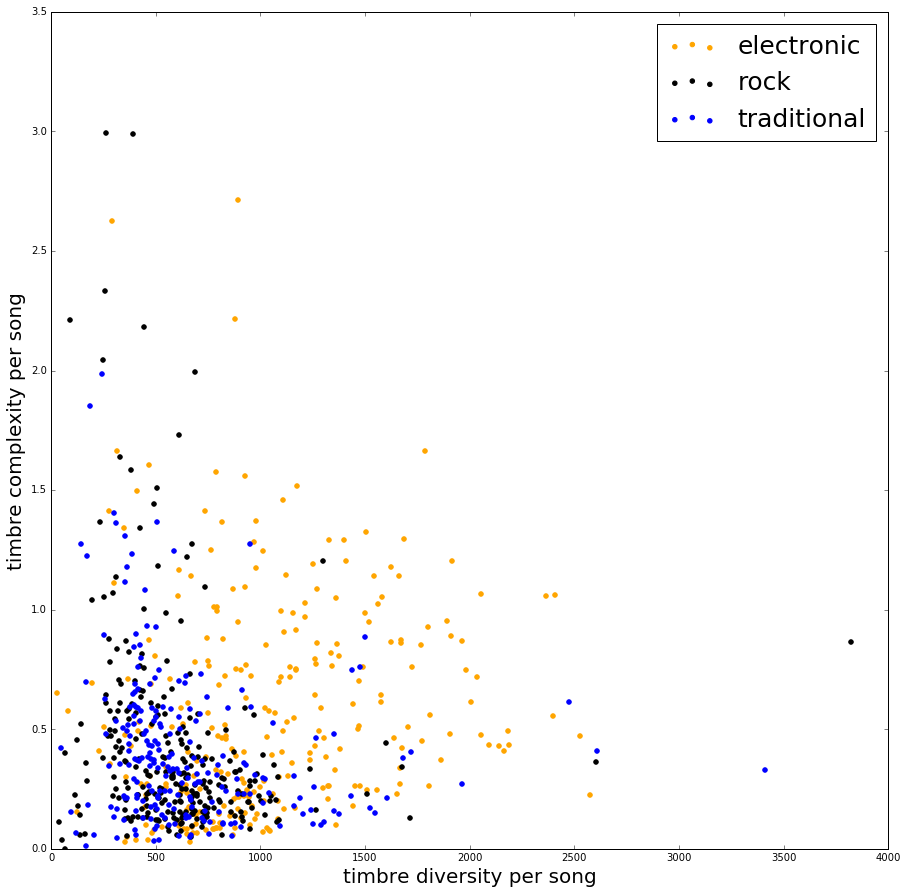

In [1091]:
#view timbre diversity and complexity across songs in genre families and check for correlation
#genre families based on top genres with the highest timbre complexity in the million song subset
#note that there are only weak correlations seen
high_electro=['hard house','tech house','dubstep','progressive house','breakbeat']
high_rock=['black metal','experimental rock','grunge','oi','heavy metal']
high_traditional=['country blues','chamber jazz','free jazz','delta blues','opera']

#plot just these genres
from scipy.stats.stats import pearsonr
fig,ax=plt.subplots(figsize=(15,15)) #figsize=(15,15)
xvalues1=[len(set(song.tcodes)) for genre in high_electro for song in new_genres[genre]] #number of distinct codewords
yvalues1=[song.tconEntropy for genre in high_electro for song in new_genres[genre]] #timbre complexity
ax.scatter(xvalues1,yvalues1,label='electronic',color='orange')
xvalues2=[len(set(song.tcodes)) for genre in high_rock for song in new_genres[genre]] #number of distinct codewords
yvalues2=[song.tconEntropy for genre in high_rock for song in new_genres[genre]] #timbre complexity
ax.scatter(xvalues2,yvalues2,label='rock',color='black')
xvalues3=[len(set(song.tcodes)) for genre in high_traditional for song in new_genres[genre]] #number of distinct codewords
yvalues3=[song.tconEntropy for genre in high_traditional for song in new_genres[genre]] #timbre complexity
ax.scatter(xvalues3,yvalues3,label='traditional',color='blue')
plt.xlim([0,4000])
plt.ylim([0,3.5])
plt.xlabel("timbre diversity per song", fontsize=20)
plt.ylabel("timbre complexity per song", fontsize=20)
#plt.title("Timbre Complexity by Number of Distinct Codewords by Song", y=1.05, fontsize=24)
plt.legend(prop={'size': 25})
#for i,song in enumerate(new_songs):
#    if yvalues[i]>2 or xvalues[i]>3000: #only label outliers
#        ax.annotate(song.terms[0],(xvalues[i],yvalues[i]))
        
print("Correlation between codewords and timbre complexity for electronic genres: ", pearsonr(xvalues1,yvalues1))
print("Correlation between codewords and timbre complexity for rock genres: ", pearsonr(xvalues2,yvalues2))
print("Correlation between codewords and timbre complexity for traditional genres: ", pearsonr(xvalues3,yvalues3))